# Module 6: CFA
# Investment Use Case: Avoiding Biases in Investment models using Machine Learning 
# =========================================================

This use case develops three equities selection models in a global equities universe. 
- **Traditional quant:** First, we examine the risk of biases of traditional quant models, based on a linear factor approach, identifying problematic assumptions and violations.
- **Hybrid Machine Learning/quant:** Second, we "enhance" the traditional approach using machine learning (ML): traditional quant+ML. We will see that this presents additional risks and biases, as we attempt to improve a traditional quant model using a neural net.
- **Interpretable machine learning equities selection**: Third, we examine a purpose designed ML approach, designed to address many of the possible biases in both traditional quant and traditional quant+ML. 

### References
[1] Philps, D., Tilles, D., & Law, T. (2021). Interpretable, Transparent, and Auditable Machine Learning: An Alternative to Factor Investing. The Journal of Financial Data Science, 3(4), 84-100
 https://jfds.pm-research.com/content/early/2021/09/22/jfds.2021.1.077
 
[2] Fama, E.F. and French, K.R., 2015. A five-factor asset pricing model. Journal of financial economics, 116(1), pp.1-22.

[3] Fabozzi, F. J., Focardi, S. M., & Kolm, P. N. (2010). Quantitative equity investing: Techniques and strategies. John Wiley & Sons.

[4] Israel, R., & Ross, A. (2017). Measuring factor exposures: Uses and abuses. The Journal of Alternative Investments, 20(1), 10-25.

[5] Levin A. (1995). Stock Selection via Nonlinear Multi-Factor Models. Advances in Neural Information Processing Systems, 8.
  https://proceedings.neurips.cc/paper/1995/file/d6ef5f7fa914c19931a55bb262ec879c-Paper.pdf 


### Code Repositories
https://github.com/danphilps/Investment-SAI






Get key packages, download data and get in good shape.

In [1]:
# package for working with tabular data
import pandas as pd 
import numpy as np

# package for navigating the operating system
import os

# Progress bar
from tqdm.notebook import tqdm

# Pretty dataframe printing for this notebook
from IPython.display import display

# Suppress warnings for demonstration purposes...
import warnings

# Type checking
import numbers

# are we running in colab?
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

## Github Repo
Many of the functions we use in this notebook are wrapped up in functional classes on the in the Investment-SAI repository, and some in the FinGov repository. For students with coding background and the interest, we encourage you to review these classes and functions.

In [2]:
# Dependency: We may have to install SHAP, an explainable AI (XAI) package onto your machine (or your Google Colab session if you are running this notebook in Colabl)
# We may need to install shap..
if IN_COLAB == True:
  !pip install shap
else:
  %pip install shap

import shap

# Clone the FinGov repo which has key utility functions for this notebook
if os.path.exists('FinGov') == False:
  !git clone https://github.com/danphilps/FinGov

# Now import the objects from the repo
os.chdir('FinGov')
from GovernanceUtils import GovernanceUtils
from FairnessUtils import FairnessUtils
import CFACreditUseCaseUtils

Note: you may need to restart the kernel to use updated packages.


Install SAI and otehr packages we will need

In [3]:
# We may need to install shap..
if IN_COLAB == True:
  !pip install investsai -q
else:
  %pip install investsai -q

# May need to upgrade ipykernel to avoid deprication warnings
if IN_COLAB == True:
  !pip install --upgrade ipykernel
else:
  %pip install --upgrade ipykernel

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Clone the FinGov repo which has key utility functions for this notebook
with warnings.catch_warnings(): # Turn warnings off for this use case
    os.chdir('..')
    if os.path.exists('InvestmentToolkit') == False:
      !git clone https://github.com/danphilps/InvestmentToolkit

    # Now import the objects from the repo
    os.chdir('InvestmentToolkit')

    # Import the functional classes we need...
    warnings.simplefilter("ignore")
    from InvestmentToolkit import SimulationUtils
    from InvestmentToolkit import RobustInvestmentUtils
    from InvestmentToolkit import LinearFactorInvesting
    from InvestmentToolkit import NonLinearFactorInvesting
    from InvestmentToolkit import SAIInvesting

# Stage1: Business Case

We need to define a ground truth, then hypotheses and then design an experimental setup to test them. In this notebook our ground truth is simply securities that generate higher returns. Note that this is prone to bias, as we may have more objectives than just outright return delivery.

# Stage2: Data

We will use a subset of a US small cap equities universe, defined as US equities with a market cap between aproximately \\$ 150m and \\$ 3bn, removing equities with incomplete data. Note that by removing equities we may expose ourselves to survivorship bias. We will use 10years of fundamental and pricing data.
First we pull in the data we need, wrangle it, examine it and prepare it.


## Stage2a. Load Data
Step into the data directory...

In [5]:

if IN_COLAB == True:
  from google.colab import drive
  import os
  drv = drive.mount('/content/gdrive')
  root_path = 'gdrive/My Drive/your_project_folder/'

  os.listdir('/content/gdrive/MyDrive/CFAI')
  os.chdir('/content/gdrive/MyDrive/CFAI')
else:
  os.chdir('..')
  os.chdir('data')


Get returns and fundamentals for our universe and load into DataFrames

In [6]:
# Extract security level returns - Monthly frequency
df_raw_sec_rets = pd.read_csv('TR_US_SMID.csv')
# Extract security level fundamentals - Monthly frequency
df_raw_sec_ff = pd.read_csv('FF_US_SMID.csv', encoding = "ISO-8859-1")

In [7]:
df_raw_sec_rets

,TICKER,FSYM_ID,DATE,CURRENCY,PRICE_DATE,MTD_RETURN_LOCAL,MTD_RETURN_USD,Unnamed: 7
0,AAALF-US,QQ4Y96-R,11/30/2012,USD,11/28/2012,NaN,NaN,55
1,AAALF-US,QQ4Y96-R,12/31/2012,USD,12/19/2012,-1.4953,-1.4953,55
2,AAALF-US,QQ4Y96-R,01/31/2013,USD,01/31/2013,14.2789,14.2789,55
3,AAALF-US,QQ4Y96-R,02/28/2013,USD,02/19/2013,NaN,NaN,55
4,AAALF-US,QQ4Y96-R,03/31/2013,USD,03/27/2013,-10.5438,-10.5438,55
...,...,...,...,...,...,...,...,...
955372,ZZLL-US,PHJKWQ-R,06/30/2022,USD,06/17/2022,5.2632,5.2632,10531
955373,ZZLL-US,PHJKWQ-R,07/31/2022,USD,07/20/2022,-12.6250,-12.6250,10531
955374,ZZLL-US,PHJKWQ-R,08/31/2022,USD,08/15/2022,28.7554,28.7554,10531
955375,ZZLL-US,PHJKWQ-R,09/30/2022,USD,09/29/2022,-4.4444,-4.4444,10531


### Selecting a subset of securities for this use-case

We select a subset of securities for this use-case to reduce processing time, and to provide a good illustration of the processes we are demonstrating. Note that this selection procedure is itself exposed to biases. 


In [8]:
# load the subset of securities to use as an example...

# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Use our pre-prepared securities list
# Note that for the purposes of this demonstration we are using preprepared securities list
# This is to reduce the processing time of the notebook, and to make the dataset less cumbersome
# **DO NOT USE THIS APPROACH IN YOUR OWN WORK**

# Enumeration of the different universes we can run this notebook with. 
class Universe_to_use:
  use_preprepared_securities = 1
  use_200_randomized_securities = 2
  use_all_securities = 3

use_preprepared_securities = Universe_to_use.use_preprepared_securities # << Change to True to observe stochastic outcomes.
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Get the subset of equities
if use_preprepared_securities == Universe_to_use.use_preprepared_securities:
  df_full_tr_hist_sec_rets = pd.read_csv('securities_subset.csv', index_col='TICKER')
elif use_preprepared_securities == Universe_to_use.use_200_randomized_securities:
  # Or ... Randomly select 250 names
  df_full_tr_hist_sec_rets = df_raw_sec_rets.sample(n=200)
  df_full_tr_hist_sec_rets = df_full_tr_hist_sec_rets.set_index('TICKER')
elif use_preprepared_securities == Universe_to_use.use_all_securities:
  # Use all equities?
  df_full_tr_hist_sec_rets = df_raw_sec_rets[['TICKER','MTD_RETURN_USD']]
  df_full_tr_hist_sec_rets = df_full_tr_hist_sec_rets.set_index('TICKER')

# print the equity universe we will be using...
print('Equities Universe for this Notebook')
display(df_full_tr_hist_sec_rets.index)

# reduce data
secs = df_full_tr_hist_sec_rets.index.unique()

df_raw_sec_rets = df_raw_sec_rets[(df_raw_sec_rets['TICKER'].isin(secs) == True)]
df_raw_sec_ff = df_raw_sec_ff[(df_raw_sec_ff['TICKER'].isin(secs) == True)]

Equities Universe for this Notebook


Index(['ACAD-US', 'PRKR-US', 'DRQ-US', 'ENSV-US', 'WTSHF-US', 'WEA-US',
       'YAMCY-US', 'HTD-US', 'MRZLF-US', 'MTSI-US',
       ...
       'FEO-US', 'TAOIF-US', 'NUS-US', 'DSNY-US', 'LGO-US', 'CLPT-US',
       'GNT-US', 'VVR-US', 'TSGTY-US', 'FCAP-US'],
      dtype='object', name='TICKER', length=200)

Extract returns for 5 US reference portfolios, or factors, and the risk free rate (RF, the 3month T-Bill yield) from the Ken French data library.

In [9]:
# Libraries...
import urllib.request
import zipfile
import csv

# Get factor returns from the Ken French data repository
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"

# Download the file and save it
# We will name it fama_french.zip file
urllib.request.urlretrieve(ff_url,'fama_french.zip')
zip_file = zipfile.ZipFile('fama_french.zip', 'r')
# Next we extact the file data
# We will call it ff_factors.csv
zip_file.extractall()
# Make sure you close the file after extraction
zip_file.close()

# Extract into a dataframe
df_ff_factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows = 3)

# Data wrangling... remove invalid rows (annual factors)
# There is white space in the date columns... strip this out
df_ff_factors.iloc[:,0] = df_ff_factors.iloc[:,0].str.strip()

# Find the start of the invalid rows and remove them all...
for row in range(1,df_ff_factors.shape[0]):
  if df_ff_factors.iloc[row,0].isnumeric() == False:
    break
df_ff_factors = df_ff_factors.drop(df_ff_factors.index[row:])

df_ff_factors.index = df_ff_factors.iloc[:,0]
df_ff_factors = df_ff_factors.drop(columns=df_ff_factors.columns[0], axis=1)

df_ff_factors = df_ff_factors.sort_index(axis=0, ascending=False)
df_ff_factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
Unnamed: 0,,,,,,
202211,4.60,-2.67,1.39,6.02,3.12,0.29
202210,7.83,1.87,8.05,3.07,6.56,0.23
202209,-9.35,-1.00,0.03,-1.50,-0.85,0.19
202208,-3.77,1.51,0.31,-4.80,1.30,0.19
202207,9.57,1.87,-4.10,0.68,-6.94,0.08
...,...,...,...,...,...,...
196311,-0.85,-0.88,1.75,-0.51,2.24,0.27
196310,2.53,-1.39,-0.10,2.80,-2.01,0.29
196309,-1.57,-0.52,0.13,-0.71,0.29,0.27


### Stage2b. Data Wrangling and Preprocessing

Shape the data (df_raw_sec_rets and df_raw_sec_ff) with dates as rows, securities as columns (and for df_ff_factors: dates as rows, factors as columns). 
The latest date should be the top row... dates should all be the same format in each file.

Returns and fundamental data: pivot data so that rows are dates (latest date in the top row), columns are factors or securities:

In [10]:
# Function to extract a single data item from the raw data. We will call it further below.
def extract_dataitem_from_ff(df_raw: pd.DataFrame,
                             col_to_extract: str = '') -> pd.DataFrame:
  
  # Sort columns and index
  df_extract = pd.pivot(df_raw, index='TICKER', columns='DATE', values=col_to_extract)
  df_extract = df_extract.sort_index(ascending=True)
  
  # Alter dates to YYYYMMDD format
  df_extract.columns = pd.DataFrame(df_extract.columns, index=None).iloc[:,0].apply(lambda x: int(x[6:] + x[0:2]))
  df_extract = df_extract.sort_index(ascending=False, axis=1)
  df_extract = df_extract.sort_index(ascending=False, axis=0)

  return df_extract

In [11]:

# Create a dictionary of all the fundamental/valuation/metric data items 
# Extract all fundamental/valuation/metric dataitems from raw data into a security/date matrix (ignore static data columns)

dict_sec_ff = dict()

#Extract all data items
for di in df_raw_sec_ff.columns:
  if di not in ['TICKER', 'SEC_NAME', 'ENT_NAME', 'COUNTRY_DESC', 'FACTSET_SECTOR_DESC', 'DATE','ADJDATE',	'ORIG_CURRENCY']:
    dict_sec_ff[di] = extract_dataitem_from_ff(df_raw_sec_ff, di)

# Backfill all values - so as we have financial reporting data populated between fiscal-end/filing dates
for idx in dict_sec_ff:
  if di not in ['TICKER', 'SEC_NAME', 'ENT_NAME', 'COUNTRY_DESC', 'FACTSET_SECTOR_DESC', 'DATE','ADJDATE',	'ORIG_CURRENCY']:
    for i in range(dict_sec_ff[idx].shape[1]):
      dict_sec_ff[idx].iloc[:, i:i+12] = dict_sec_ff[idx].iloc[:, i:i+12].fillna(method="bfill", axis=1)




#### Refining our universe
Remove equities with < 60% of returns populated; cap returns at +500% 

In [12]:
# pivot total returns
df_sec_rets = extract_dataitem_from_ff(df_raw_sec_rets, 'MTD_RETURN_USD')
df_sec_rets = df_sec_rets/100

# Transpose
df_sec_rets = df_sec_rets.T

# ***********************************************
# Remove underpopulated **** Note that this could 
# Kill all securities with any na returns in the period.
secs_valid = (df_sec_rets.isna().sum(axis=0) < (df_sec_rets.shape[0] * 0.60))
df_sec_rets = df_sec_rets[df_sec_rets.columns[secs_valid]]
# ***********************************************

# Get the equities universe
secs_universe = list(dict_sec_ff.values())[0].index.unique()
secs_universe = [col for col in df_sec_rets.columns if col in secs_universe]

# Only use returns where we have valid fundamental data
df_sec_rets = df_sec_rets[secs_universe]

# Cap all returns to 500%
df_sec_rets[df_sec_rets>5] = 5

#### Prepare factor data

In [13]:
# Get FF factors sorted and transposed...
# Rows are dates (latest date in the top row), columns are factors or securities...
df_ff_factors = df_ff_factors.sort_index(ascending=False)
# Set row index as dates
df_ff_factors.index = df_ff_factors.index.astype(int)
# Force type to float
df_ff_factors = df_ff_factors.astype(dtype=float)
# stated at percentages? No...
df_ff_factors = df_ff_factors/100

# Separate RF from the Factor DataFrame
df_tb3ms = df_ff_factors[['RF']]

# Set row index as dates
df_tb3ms.index = df_tb3ms.index.astype(int)

# Remove RF from the factor data
df_ff_factors = df_ff_factors[['Mkt-RF','SMB','HML','RMW','CMA']] # << AN error here may indicate we have picked up the wrong factor file.


Let's check our data... rows are dates; equities/factors are columns; returns stated as percentages 

In [14]:
display(df_tb3ms.head())
display(df_ff_factors.head())
display(df_sec_rets.head())

,RF
Unnamed: 0,
202211,0.0029
202210,0.0023
202209,0.0019
202208,0.0019
202207,0.0008


,Mkt-RF,SMB,HML,RMW,CMA
Unnamed: 0,,,,,
202211,0.0460,-0.0267,0.0139,0.0602,0.0312
202210,0.0783,0.0187,0.0805,0.0307,0.0656
202209,-0.0935,-0.0100,0.0003,-0.0150,-0.0085
202208,-0.0377,0.0151,0.0031,-0.0480,0.0130
202207,0.0957,0.0187,-0.0410,0.0068,-0.0694


TICKER,WW-US,WABC-US,VVR-US,VSEC-US,VCV-US,URG-US,ULH-US,UEIC-US,TWO-US,TELL-US,...,ATRI-US,APYX-US,APOG-US,AORT-US,ALNY-US,ALIM-US,ALG-US,AGM-US,ACAD-US,AAON-US
DATE,,,,,,,,,,,,,,,,,,,,,
202210,0.150127,0.199656,0.019447,0.307627,-0.022223,0.183486,0.008827,0.037621,0.072289,0.129707,...,0.062496,0.113586,0.206526,-0.193642,0.035472,0.027559,0.245407,0.161993,-0.020171,0.196919
202209,-0.247126,-0.065416,-0.029658,-0.154122,-0.108736,-0.210145,-0.128667,-0.115160,-0.280412,-0.402500,...,-0.061173,-0.216405,-0.064153,-0.375451,-0.031499,-0.248521,-0.064928,-0.084162,-0.004260,-0.062630
202208,-0.213855,-0.061024,-0.001197,-0.002384,-0.059334,0.159664,0.214975,-0.198919,-0.098513,0.075269,...,-0.106451,-0.394292,-0.018505,0.130612,0.455013,0.183888,0.010432,-0.009520,0.118448,-0.044707
202207,0.039124,0.078153,0.006915,0.119599,0.027597,0.122642,0.100330,0.085256,0.117725,0.248322,...,0.074802,0.614334,0.067074,0.038136,-0.026123,0.043876,0.113214,0.129442,0.042583,0.098795
202206,-0.098731,-0.075569,-0.011145,-0.032939,-0.031999,-0.131148,-0.017249,-0.045896,-0.067416,-0.375262,...,0.003267,-0.034596,-0.057212,-0.034765,0.159380,-0.103279,-0.010201,-0.060446,-0.127554,0.025527


Mostly all good, but we have a date alignment issue. 

#### Data Wrangling: Date alignment
Ensure date alignment across all data we are using... enforce a common end date by taking the earliest end date across our DataFrames. Enforce a  a common start date by taking the latest end date across our DataFrames.

In [15]:
# Enforce the end date...
# Get the date_end that we will use, this will be the study end date...
date_end = min([max(df_tb3ms.index.astype(int)), max(df_ff_factors.index.astype(int)), max(df_sec_rets.index.astype(int))])

# Remove all date columns after the date_end
df_tb3ms = df_tb3ms.drop(index=df_tb3ms.index[df_tb3ms.index.astype(int) > date_end])
df_ff_factors = df_ff_factors.drop(index=df_ff_factors.index[df_ff_factors.index.astype(int) > date_end])
df_sec_rets = df_sec_rets.drop(index=df_sec_rets.index[df_sec_rets.index.astype(int) > date_end])

# Enforce the start date...
# Get the date_start that we will use, this will be the study start date...
date_start = max([min(df_tb3ms.index.astype(int)), min(df_ff_factors.index.astype(int)), min(df_sec_rets.index.astype(int))])

# Remove all date columns after the date_end
df_tb3ms = df_tb3ms.drop(index=df_tb3ms.index[df_tb3ms.index.astype(int) < date_start])
df_ff_factors = df_ff_factors.drop(index=df_ff_factors.index[df_ff_factors.index.astype(int) < date_start])
df_sec_rets = df_sec_rets.drop(index=df_sec_rets.index[df_sec_rets.index.astype(int) < date_start])

Sanity check the data for errors and mistakes. Eye ball the distributions and correlations too. Here are some of the checks that should be carried out at a minimum:

1. Date alignment errors
2. Check all percentages are formatted correctly
3. Check nan values have a low count

#### Governance: Validation check on our data
Validate the input data to ensure it is correct, the dates are correctly aligned, formats and conventions are aligned (e.g., whether numbers are represented decimals (0.10) or percentages (10%)) and that there are no obvious issues with the data. 

In [16]:
# Sanity checking
# 1: Dates are aligned?
if  (df_tb3ms.index.equals(df_ff_factors.index) == False) | (df_ff_factors.index.equals(df_sec_rets.index) == False):
  raise TypeError('Sanity: Dates are not aligned...')

# 2: Percentages are percentages (not decimals)? 
# Check df_tb3ms median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_ff_factors.iloc[:,:].abs().median(skipna=True).median(skipna=True)
sd = df_ff_factors.iloc[:,:].std(skipna=True).median(skipna=True)
if (med_abs + sd*5 < df_tb3ms.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_tb3ms.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_ff_factors values to be outside of a sensible range...')  
if (med_abs + sd*5 < df_sec_rets.abs().median(skipna=True).median(skipna=True)) | (med_abs - sd*5 > df_sec_rets.abs().median(skipna=True).median(skipna=True)):  
  raise TypeError('Sanity: df_ff_factors values to be outside of a sensible range...')  

# Check df_ff_factors median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_tb3ms.iloc[0,:].abs().median(skipna=True) # only one row... only one median call needed
sd = df_tb3ms.iloc[0,:].std(skipna=True) # only one row... no median call needed
if (med_abs + sd*5 < df_ff_factors.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_ff_factors.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_tb3ms values to be outside of a sensible range...')  
if (med_abs + sd*5 < df_sec_rets.abs().median(skipna=True).median(skipna=True)) | (med_abs - sd*5 > df_sec_rets.abs().median(skipna=True).median(skipna=True)):  
  raise TypeError('Sanity: df_tb3ms values to be outside of a sensible range...')  

# Check df_sec_rets median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_sec_rets.abs().median(skipna=True).median(skipna=True)
# median of each row, median across rows
sd = df_sec_rets.std(skipna=True).median(skipna=True) # std of each row, median across rows
if (med_abs + sd*5 < df_tb3ms.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_tb3ms.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_sec_rets values appear to be outside of a sensible range...')  
if (med_abs + sd*5 < df_ff_factors.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_ff_factors.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_sec_rets values appear to be outside of a sensible range...')  

# 3: Many nan? 
if df_tb3ms[df_tb3ms==np.nan].count().sum() / (df_tb3ms.shape[0]*df_tb3ms.shape[1]) > 0.33:
  raise TypeError('Sanity: df_tb3ms; > 33% of values are nan')  
if df_ff_factors[df_ff_factors==np.nan].count().sum() / (df_ff_factors.shape[0]*df_ff_factors.shape[1]) > 0.33:
  raise TypeError('Sanity: df_ff_factors; > 33% of values are nan')  
if df_sec_rets[df_sec_rets==np.nan].count().sum() / (df_sec_rets.shape[0]*df_sec_rets.shape[1]) > 0.33:
  raise TypeError('Sanity: df_sec_rets; > 33% of values are nan')  


## Stage2c. Exploratory data analysis (EDA)

For investment models EDA should encompass exploring data types (interval, cardinal, nominal), distributions, correlations, and more. It is a good idea to examine pairwise distributions of input variables to ensure colinearities (and other relationships) do not exist.  

#### Bias Alert: Linear Regression Violations

The four most common violations of classical regression theory that occur in cross-sectional factor models are: 

1. multicollinearity\*: correrlation in input variables
2. the errors in variables problem**: where incorrectly measured variables or proxy variables are used
3. common variation in residuals\** such as heteroskedasticity
4. endogeneity\***: where the returns from equities we are modelling affect the input variables. This might be caused by too many investors using similar models.

\*: Multicolinearity is best dealt with by removing collinear variables from the regression
\**: There are statistical techniques that address 2, and 3.
\***: Endogenous bias is extremely difficult to detect and deal with. We will come onto this.


In [17]:
# Functions for EDA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import shapiro

# Function we will call to add R2 and p-val to the off-diagonal cells of the pair plot
def R2func(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    _, _, r, p, _ = stats.linregress(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate(f'p-val = {p:.2f}', xy=(.1, .8), xycoords=ax.transAxes)

# Function we will call to add normality test stat and p-val to diagnonal cells of pair plot
# Note that inputs to linear regression are not required to be normally distributed.
def normalityfunc(x, hue=None, ax=None, **kws):
    """Plot the Shapiro Wilk p-value in the top left hand corner of diagonal cells."""
    stat, p = shapiro(x)
    ax = ax or plt.gca()
    ax.annotate(f'Shapiro-Wilk stat = {stat:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate(f'p-val = {p:.2f}', xy=(.1, .8), xycoords=ax.transAxes)


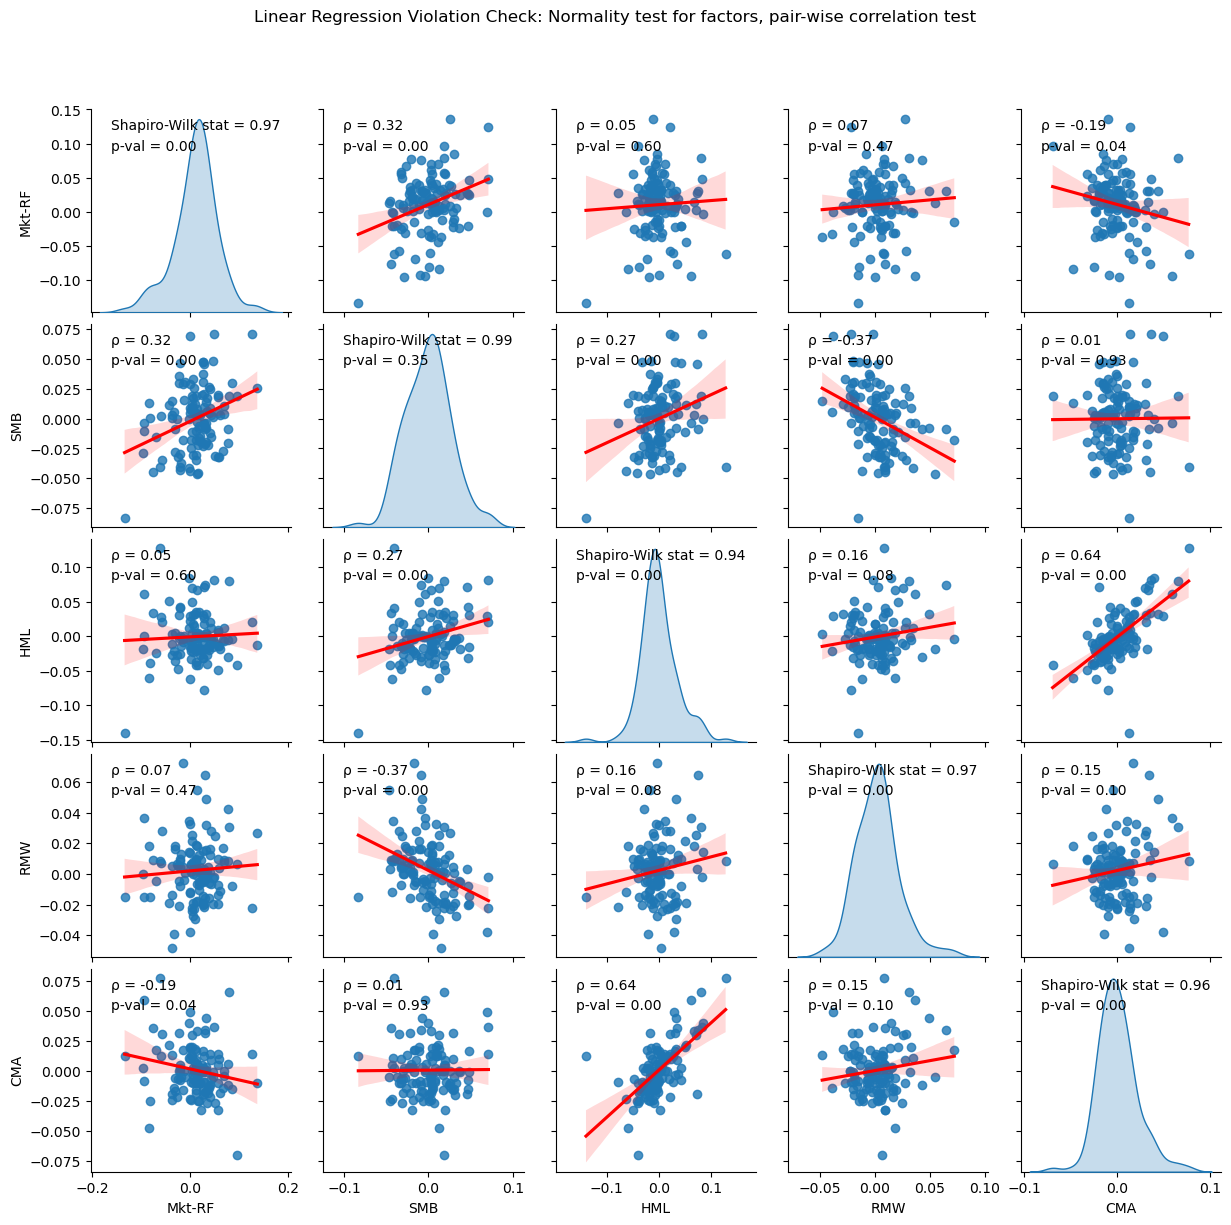

In [18]:
# Run EDA Functions on our dataset

# Generate pairplot
pp = sns.pairplot(df_ff_factors, kind='reg', diag_kind='kde',
             plot_kws={'line_kws':{'color':'red'}})

# Run the R2func for all off diagnonal cells, and normalityfunc for the diagonal ones...
pp.map_lower(R2func)
pp.map_upper(R2func)
pp.map_diag(normalityfunc)

# Title...
pp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp

pp.fig.suptitle('Linear Regression Violation Check: Normality test for factors, pair-wise correlation test')

plt.show()


Eyeballing our data we can see from the frequency distributions on the diagonal, that all variables have approximately normally distributed. It can also be noted that HML and CMA are somewhat correlated, which may cause colinearity issues with the linear regression models we will use later.

# Stage3: Model Design

#### Bias Alert: Complexity Bias
There is a balancing act between model complexity and the data available, and if our model becomes too complex for the amount of data we will likely overfit to the data, and our model will not perform well out of sample. It will be a bad predictor. The more samples we have, and the more accurate the data, the more accurate our model will be. The more data we have the more features and model parameters  (ie complexity) we can employ to approximate our target function. 

In practice, historic simulations require relatively large amounts of data to avoid overfitting. A relatively long history of returns is required to learn a linear regrssion model with many input variables[1], less for a classification model. ML models generally have more parameters than traditional linear models and therefore we need even more data for training. In short, we may not have high enough frequency data to train a stable model. This problem is exaccerbated when running simulations, as to avoid data snooping biases we can only use a subset of our full dataset that preceeds each simulation date.   

For linear factor models, the analogue is that these models assume: 
$$N >> K$$
[2] , a serious limitation requiring explicit dimensionality reduction, in a world with expanding data resources .


So how much data do we need for our chosen model? And what is the maximum number of features we should use?

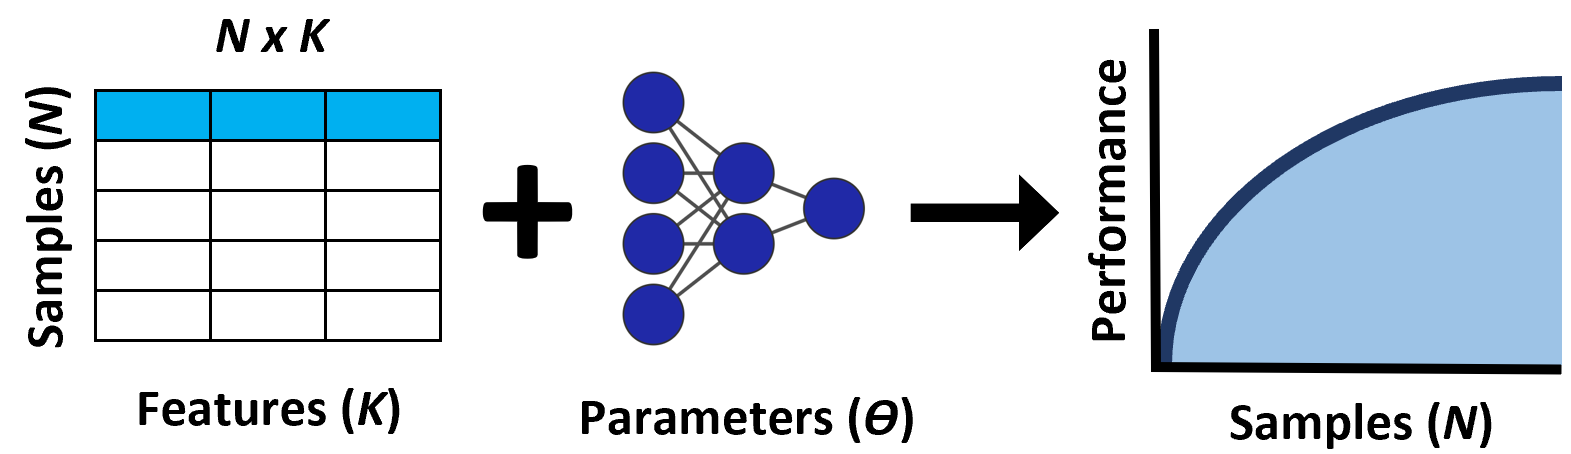


### Model complexity1: Instances vs features and classes used
A rule of thumb for the number of instances, N, needed to train a stable model with K input features, for a classification model with C categories to classify:

$N ≥ 10 K C$

instances. For a regression model:

$N ≥ 50 K$

instances are suggested.


### Model complexity2: Instances vs parameters
A rule of thumb for the limit on number of parameters, $|θ|$, our model should have, given the size of our training data [3], we suggest this: 

$|θ| ≤ N/10$ 


[1] Robert C. Merton, “On Estimating the Expected Return on the Market: An Exploratory Investigation,” Journal of Financial Economics, 8 (1980), pp. 323–361.

[2] Valliappa Lakshmanan, Sara Robinson, and Michael Munn. Machine learning design patterns. O’Reilly Media, 2020

[3] Kevin P. Murphy, Probabilistic machine learning: an introduction. MIT press, 2022

In [19]:
#***********************************************************************
#*** Complexity bias Sanity Check!***
#***********************************************************************  
def bias_complexity_check_regression(no_of_instances: int,
                          no_of_features: int = 0,
                          no_of_parameters: int = 0) -> (bool, int, int):

  '''
  Check the complexity of the mode based on rules of thumb.

  Args:
    no_of_instances: Number of rows in your dataset
    no_of_features: Number of columns
    no_of_parameters: Number of weights/coefficients/parameters in your model
      
  Returns:
      rf: sklearn model object
      
  Author:
      failed: Did the complexity check fail? Too complex...
      feature_max: maximum number of features you shluld have given the problem type and instances
      param_max: maximum number of weights/coefficients/parameters in your model given the problem type and instances
  '''

  failed = False
  cb_K = no_of_features
  cb_n = no_of_instances
  
  # 1. Feature complexity: n ≥ 50 K
  if cb_n > 50 * cb_K:
    failed = True
  
  feature_max = int(round(cb_n / 50, 0))

  # 2. Parameter complexity: ¦θ¦ ≤ n/10
  #
  # The number of model parameters (ie weights) should observe the constraint
  # wrt training instances, n, features, K:
  #
  # |theta| >= n/10  
  param_max = int(round(cb_n / 10, 0))
  
  if no_of_parameters > param_max:
    failed = True

  return (failed, feature_max, param_max)


## 3a. Traditional Quantitative approach: Linear Factors

We will test a simple, fundamental factor model applied to investing stocks in our universe, also known as a time-series factor model, after Fama and French. This has the form:
$$
R_{it} = α_{i} + \sum\limits_{j=1}^{K} \beta_{ij} f_{ij} + ϵ_{ij} \qquad \text{where}\; i=1,\dots, N\; j=1,\dots, K
$$
Where $R_{it}$ is the return of equity $i$ at time $t$, $\beta$ is the exposure (loading) of equity $i$, representing an observed source of inefficiency such as value, $f$ is the return of a reference portfolio $j$. 

In practice we will use a vectorized version of this factor model, which is much faster:

$$
R_{t} = \mathbf{α +β f_{t} + ϵ_{t}}
$$


We will first learn the loadings of each equity to each of the factors in the dataset, and we will then use these loadings and the assumed future factor returns to determine the expected return of each equity to form model portfolios.   


#### Bias Alert: Researcher bias

Biases that can arise due to the researcher being influenced in both data collection, data exploration and modelling approaches proposed by previous research. Factor investing, provides a number of possible areas for researcher bias, including model design and factors to use.

#### Bias Alert: Sample Distribution Bias

If the training data and the actual data to be predicted come from different distributions, this would likely challenge to the generalization ability of a model (ie how well it performs on future input data). If a parametric model is used, such as a linear factor model, the risks of shifting distributions are likely to be greater still, as normality assumptions may be violated, even if normlization/standardization of the input data is carried out.   

We now specify our model training process, using OLS regression. We will wrap this up as a function, so as we can call it multiple times to generate return simulations over the study term.

Note that we sanity check parameters, to provide basic checks, and we analyse the residuals produced by the model to ensure residuals are normally distributed (using a SHapiro-Wilk test in this case, with the option of generating a scatter plot in the function too).
Let us run the function, using our 5 factor regression on the first security in the dataset, column=0.

Many refinements can be made to this simple model.

### 3a. i) Prepare data

Our data is wrangled and ready but we need to shape it to pass it into our model to train and predict.



### 3a. ii) Forecast Equity Level Expected Returns

As one function call we can train our model and predict our expected returns. Wrapped in this one function we train our model, passing in training data (in this case forming a training window of the past 36months), ensuring that this data is at or before our assumed execution date, and    

In [20]:
# Run the function with our data
df_all_er = LinearFactorInvesting.factormodel_forecast_all_er(df_benchmark_trades=None, # Only use df_benchmark_trades positions with a non NaN value
                                        df_tb3ms=df_tb3ms, # Risk free rate
                                        df_sec_rets=df_sec_rets, # security level returns histories, monthly in USD
                                        df_ff_factors=df_ff_factors, # factor returns monthly in USD
                                        window_size=36, # training window size
                                        factor_return_history=36) # prediction: return history of factors to assume will persist going forwards

# Test an example
test_this_equity = df_all_er.columns[0]
df_all_er.columns.get_loc(test_this_equity)

0it [00:00, ?it/s]

0

#### Example: Expected Returns of a Single Equity 
Let us train a factor model for on a single equity in the dataset using the past 36months of data, and then calculate this security's expected returns. We can also check the residuals of this model and check over the statistics. Note that the residuals do not appear entirely normal.

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


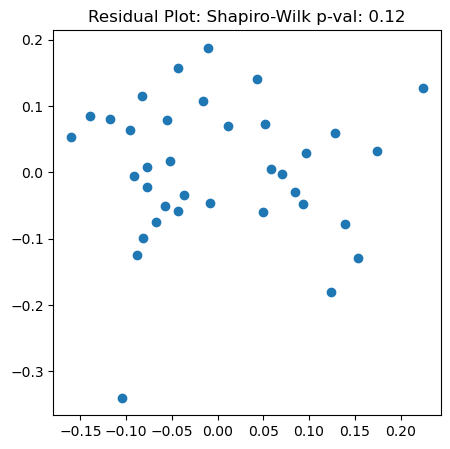

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     6.810
Date:                Wed, 18 Jan 2023   Prob (F-statistic):           0.000237
Time:                        12:35:30   Log-Likelihood:                 33.008
No. Observations:                  36   AIC:                            -54.02
Df Residuals:                      30   BIC:                            -44.52
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0093      0.020     -0.473      0.6

In [21]:

# Get an example equity
i = df_sec_rets.columns.get_loc('VSEC-US') 
t = 19 # Run the model as if we were at a timepoint 19months ago.

# Run our function on the first security (sec_col_no=0), returning only the model object, and Shapiro-Wilk stat and p-value
ols_model, y, y_hat = LinearFactorInvesting.factormodel_train_single_security(sec_col_no=i, 
                                             df_tb3ms=df_tb3ms, 
                                             df_sec_rets=df_sec_rets, 
                                             df_ff_factors=df_ff_factors, 
                                             date_start=t+36, 
                                             date_end=t, 
                                             plot_residual_scatter=True)
# Examine the fit, coefficients and OLS analytics.
print(ols_model.summary())

# Forecast E(R) for this security.
df_equity_er = LinearFactorInvesting.factormodel_forecast_er(df_stock_factor_loadings=pd.DataFrame(ols_model.params, index=None), 
                                df_ff_factors=df_ff_factors, 
                                r_f=df_tb3ms.iloc[0,0],
                                date_start=t+36, 
                                date_end=t,)

print("Expected Return Forecast for this equity")
print(df_equity_er)


### 3a. iii) Construct Model Portfolios

In each period we select the top quartile of our equity forecasts, and generate a DataFrame of equal weighted equities that reside in this quantile.
Next we assume a 6month rebalance frequency, and simulate the past returns of this portfolio over the study term

#### Bias Alert: Backtesting Bias

Back-testing bias includes forward-look (or data snooping) bias, where an analyst will check the performance of an approach over the past, and will tend to reject all approaches that perform poorly. In a sense the analyst becomes endogenous to the model, using a look-ahead to bias model selection to only those models that have worked well. 

This issue can be addressed by testing only a small number of approaches (i.e., avoiding violation of independence assumptions) with strong investment rationales (i.e., causality) and/or by comparing the simulated returns to the possible empirical outcomes using target shuffling. 

#### Bias Alert: Time-Interval/Forward Look Bias
When researcher selects a specific timeframe for training vs. validating vs. testing to support hypotheses and/or uses “restated” data not available during the time under study. 

In [22]:
# Get the top 25% of equities by exepected return over the study term
df_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_all_er, 
                                        rebalance_freq=6, 
                                        min_quantile_to_buy=0.75)

0it [00:00, ?it/s]

Top quantile generated


### 3a. iv) Simulate Returns 
We can now conduct an historic simulation.  We iterate from the earliest time period where we have a model portfolio to the most recent period, generating expected returns for each equity in our model portfolio as we step forward through time, and simulating a rebalance event when there is a new model portfolio in a time period we step into. 
We combine step ii) Forecast Equity Level Expected Returns, iii) Select Top Quartile Equities, and iv) Simulate Returns, into the next code block:

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

,Analytics
Total Return (TR)(annualized),0.120638
Standard deviation (SD) (annualized),0.286069
Sharpe Ratio (TR/SD),0.421711
Hit rate (monthly),0.636364


,Descriptive Stats
Mean (TR),0.013032
Median (TR),0.012940
Variance (TR),0.006820
Skewness (TR),-0.021185
Kurtosis (TR),1.542542


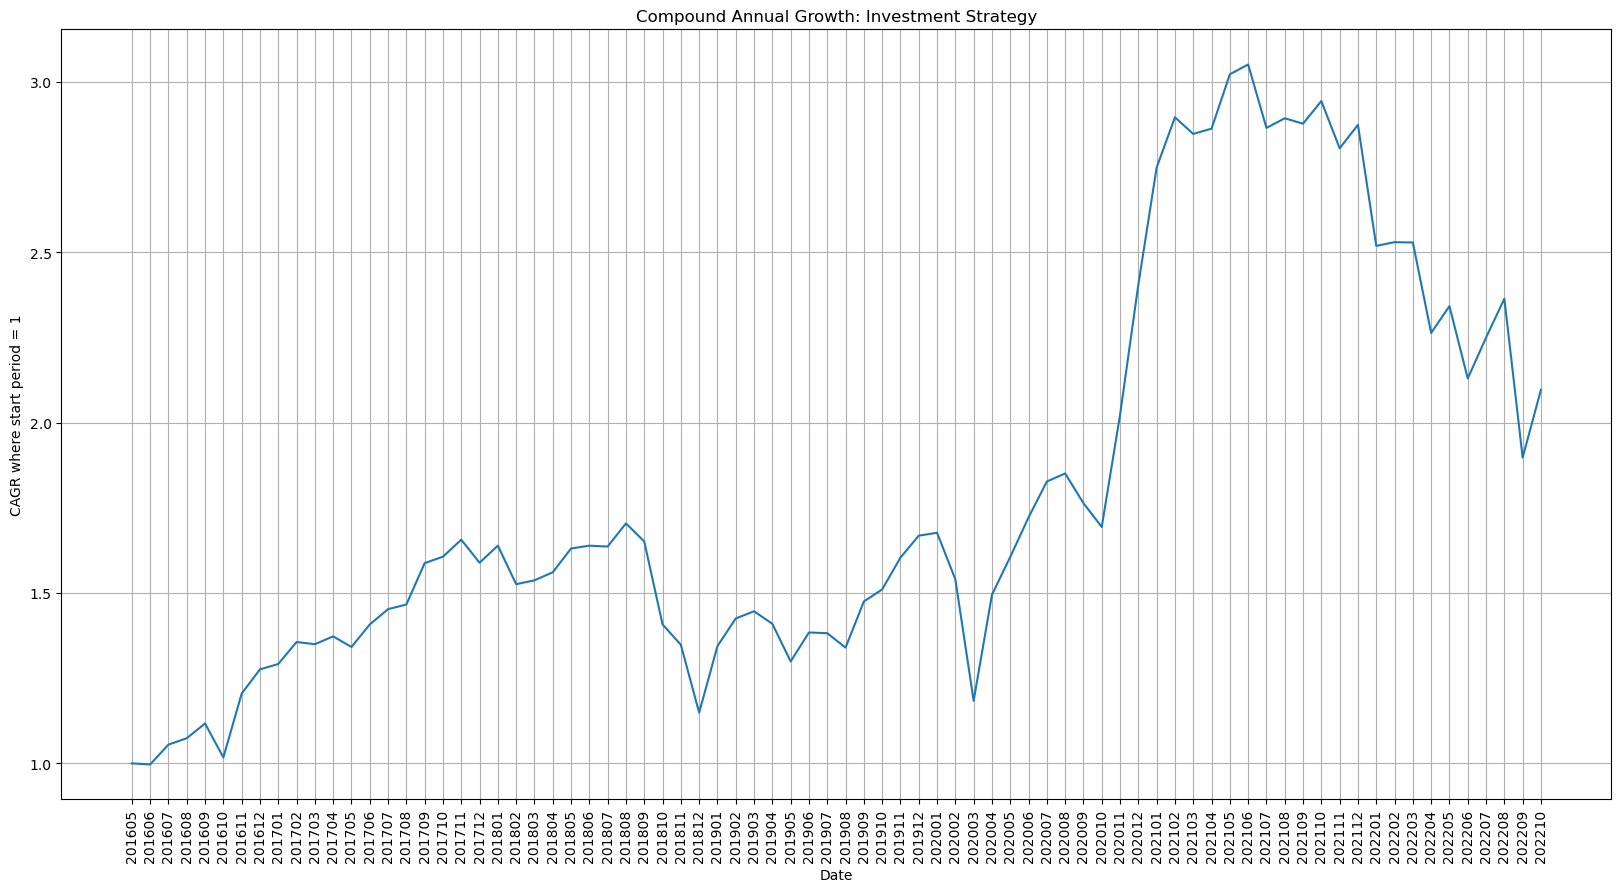

In [23]:


#====================================
# Run the Linear factor model
#====================================

# FF model
df_lin_all_er = LinearFactorInvesting.factormodel_forecast_all_er(df_benchmark_trades=None,
                                        df_tb3ms=df_tb3ms, 
                                        df_sec_rets=df_sec_rets,
                                        df_ff_factors=df_ff_factors,
                                        window_size=36,
                                        winsorize_er=0)

# Run the function to establish simple positio sizes based
df_lin_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_lin_all_er, 
                                        rebalance_freq=6, 
                                        min_quantile_to_buy=0.75)

# Run the simulation function
df_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, 
                         rebalance_freq=6, 
                         df_sec_rets=df_sec_rets,
                         date_start_of_sim=79)  


Now we construct a simple benchmark from our universe...

0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

,Analytics
Total Return (TR)(annualized),0.118827
Standard deviation (SD) (annualized),0.216353
Sharpe Ratio (TR/SD),0.549228
Hit rate (monthly),0.688312


,Descriptive Stats
Mean (TR),0.011500
Median (TR),0.014161
Variance (TR),0.003901
Skewness (TR),-0.675099
Kurtosis (TR),2.545039


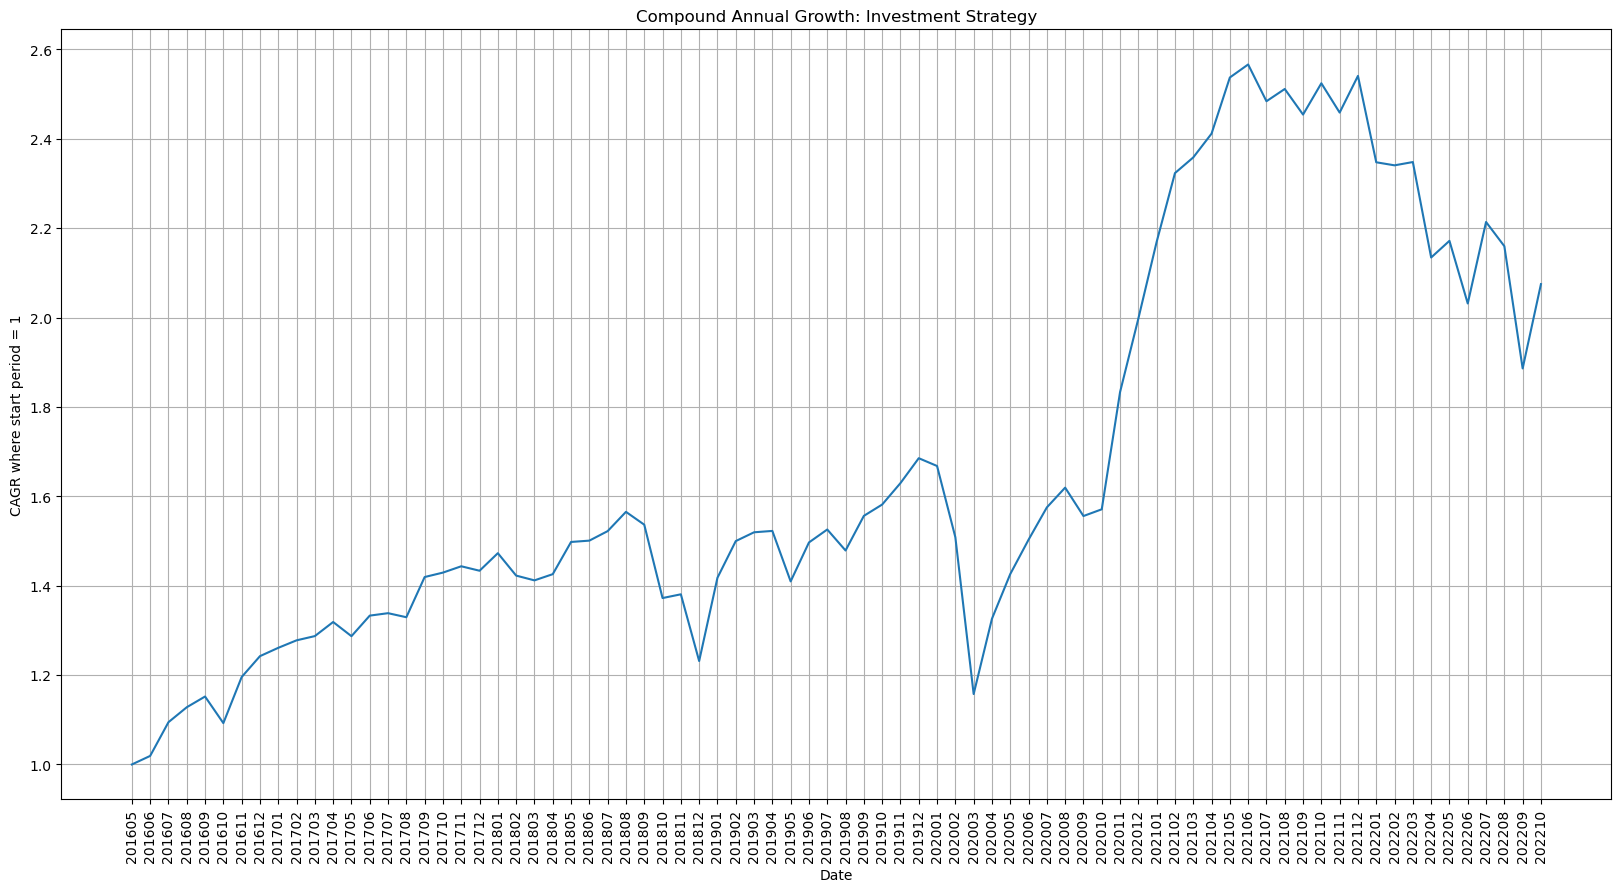

In [24]:
#====================================
# Create universe benchmark
#====================================
# Run the function to establish simple positions
df_benchmark_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_lin_all_er, rebalance_freq=6, min_quantile_to_buy=0)

df_sec_rets_copy = df_sec_rets.copy(deep=True)
df_sec_rets_copy[df_sec_rets_copy>5] = 5

# Create an equal weighted benchmark of all valid securities
# Run the simulation function
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades, 
                                    rebalance_freq=6, 
                                    df_sec_rets=df_sec_rets_copy, 
                                    date_start_of_sim=79)  

0it [00:00, ?it/s]

,Analytics
Total Return (TR)(annualized),0.120638
Standard deviation (SD) (annualized),0.286069
Sharpe Ratio (TR/SD),0.421711
Hit rate (monthly),0.636364


,Descriptive Stats
Mean (TR),0.013032
Median (TR),0.012940
Variance (TR),0.006820
Skewness (TR),-0.021185
Kurtosis (TR),1.542542


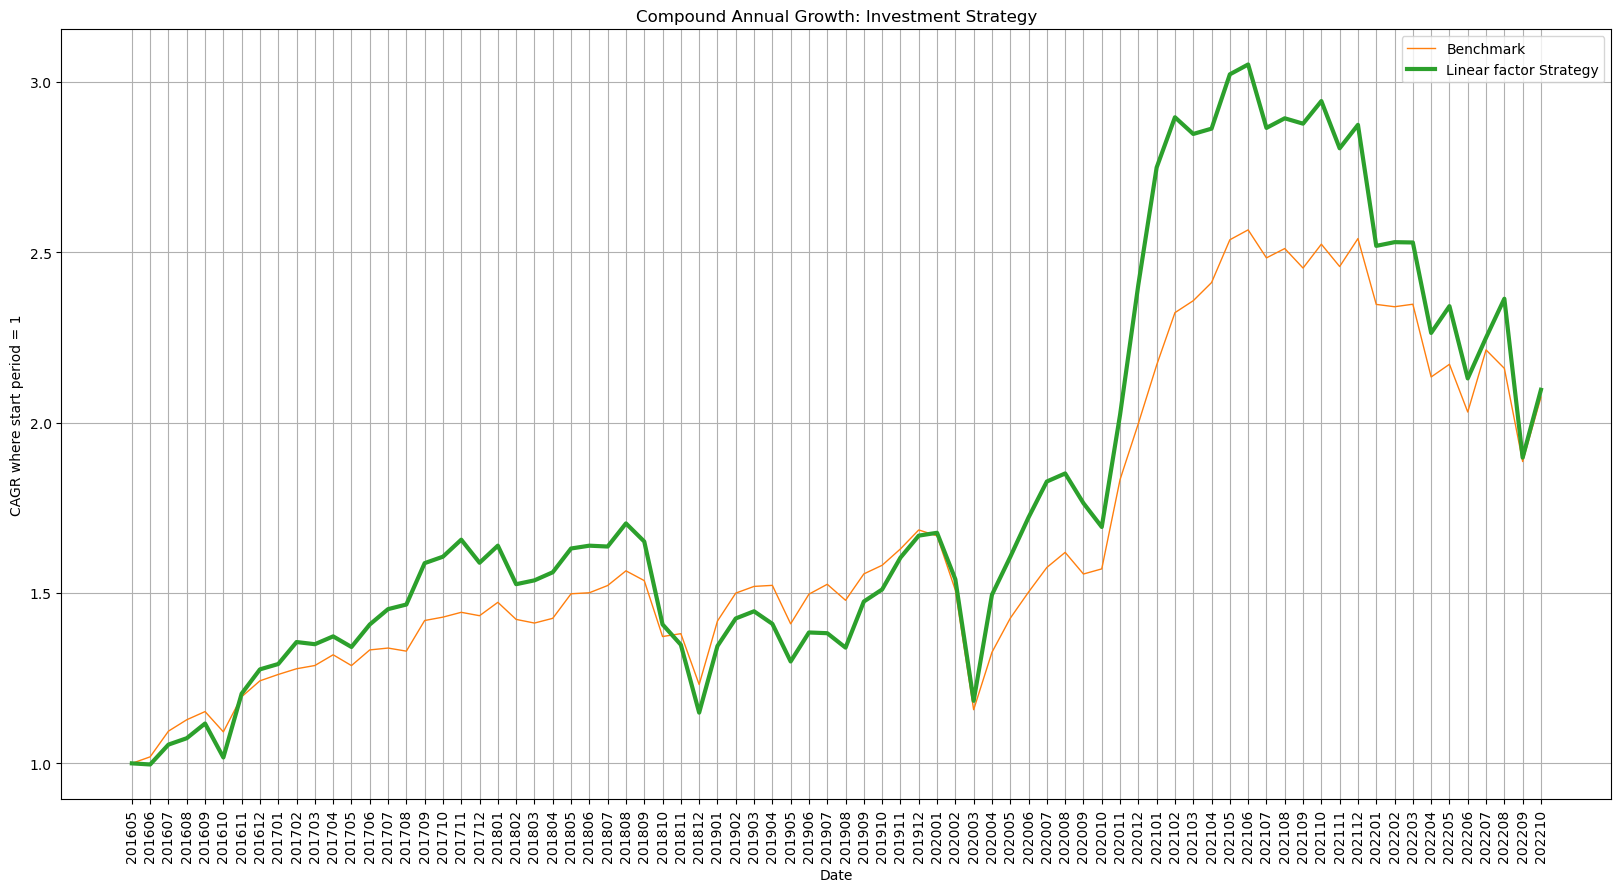

In [25]:
# Plot the linear-factor model CAGR vs the benchmark
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, 
                         rebalance_freq=6, 
                         df_sec_rets=df_sec_rets,
                         print_chart=False,
                         date_start_of_sim=79)  

# Chart
p = SimulationUtils.sim_chart(df_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy', emphasize=True)
p.legend()
p.show()

### 3a. v) Assess Returns

We can observe the total returns of our model and its performance against the benchmark but return simulations can give a misleading impression of how significant performance or risk adjusted returns would have been. As we saw in previous modules, we can construct an empirical distribution of possible returns using "target shuffling". This allows us to look at many of the combinations of securities we could have held over the study term which allows us to compare our results to the results of these randomly selected portfolios.  

In [26]:

# get an empirical distribution of outcomes using target-shuffling "lite"
dt_target_shuffling_dist = RobustInvestmentUtils._target_shuffling_lite_get_dist(df_opportunity_set_trades=df_benchmark_trades, # Randomly allocate to equities ino our universe
                                      min_quantile_to_buy = 0.75, # Same rebalance assumptions as our approach
                                      df_sec_rets=df_sec_rets, 
                                      rebalance_freq=6, # Same rebalance assumptions as our approach
                                      iterations=100) # Number of portfolios to randomly create and simulate

0it [00:00, ?it/s]

Factor Model


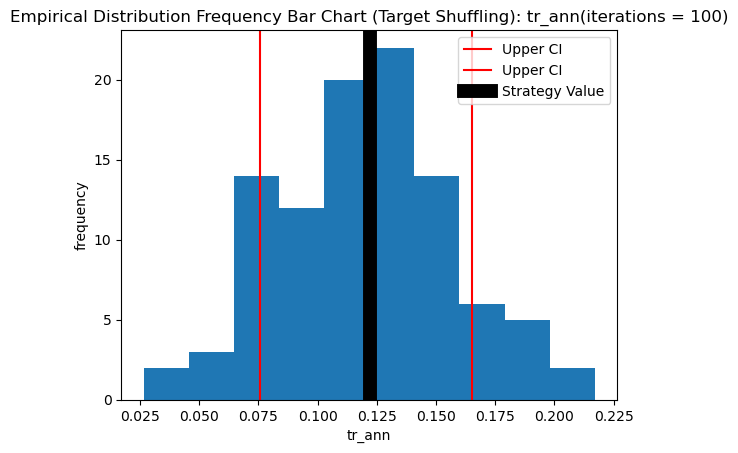

Empirical probability value of the strategy: tr_ann:0.52
Benchmark


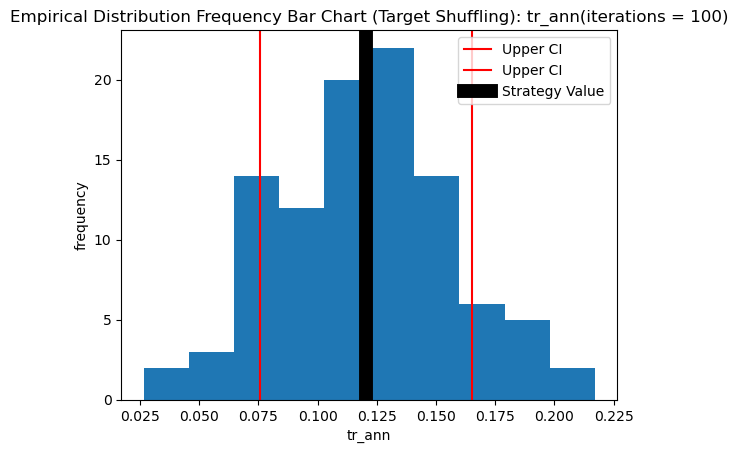

Empirical probability value of the strategy: tr_ann:0.49


In [27]:
# check the performance of the simultation using target shuffling lite, to form an empirical distributon of returns
# simulation...
print('Factor Model')
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_lin_sec_cagr)
# benchmark
print('Benchmark')
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_benchmark_sec_cagr)

We can conclude that factor models would have done a poor job of adding value over the benchmark over this period of time, which may cause us to decide to reject this approach. 

#### Bias Alert: Certainty bias

Any opinion offered about the probability, likelihood, certainty, or similar property for a hypothesis cannot be derived from statistical methods alone. In particular, significance tests and confidence intervals do not by themselves provide a logically sound basis for concluding an effect is present or absent with certainty or a given probability. This point should be borne in mind whenever one sees a conclusion framed as a statement of probability, likelihood, or certainty about a hypothesis. Information about the hypothesis beyond that contained in the analyzed data and in conventional statistical models (which give only data probabilities) must be used to reach such a conclusion; that information should be explicitly acknowledged and described by those offering the conclusion. Bayesian statistics offers methods that attempt to incorporate the needed information directly into the statistical model; they have not, however, achieved the popularity of P values and confidence intervals, in part because of philosophical objections and in part because no conventions have become established for their use.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4877414/

#### Bias Alert: Endogenous bias
Endogeneity bias is not a simple violation and there is no easy statistical solution. It has serious consequences for outcomes, where in the presence of endogenous variables OLS learns biased and inconsistent parameters. P-values can be seriously misleading. All it takes is one endogenous variable to seriously distort ALL OLS parameters.
https://artnet.unescap.org/tid/artnet/mtg/gravity09_tues3.pdf

One potentially concerning endogeneity is self-fulfilling prophecy of factor investing, where equities with high correlations to commonly used factors would cause investments in those equities, causing price appreciation, affirming that the correlations with those factors caused the price rises.


## 3b. Factor Approach with Non-linear Regression

We now examine applying machine learning to a traditional quantative framework, which attemptsd to address some eaeknesses of factor models but introduces additional risks and complexity.

Traditional linear factor approaches, after Fama and French, tend to assume persistent long-run factors returns, and that an equity's loadings to these factors can be (linearly) multiplied into these factor returns to find their expected return. It is possible to change this assumption by introducing a nonlinear relationship between our equities' factor loadings and expected returns. We can train a ML model to find a nonlinear function to fit all of our $N$ equities' $K$ loadings, $\beta_ij$, to all their returns, $R_{it}$:

$$
R_{it} =\overset{̃}{f}_{j=1}(β_{i1}, β_{i2}, …, β_{iK}, f_{i1}, f_{i2}, …, f_{iK})
$$

Where $R_{i}$ is the return of equity $i$ at time $t$, $\beta$ is the exposure (loading) of equity $i$, representing an observed source of inefficiency such as value, $f$ is the return of a reference portfolio $j$. 


To approximate this function, $\overset{̃}{f}()$, is substantially more challenging than simply assuming a linear relationship as factor models tend to. We may be attemptiong to remove a bias in linear factor models, but we are now open to introducing biases in both factor based models, in ML models, and in combining the two.

We use an MLP neural net to approximate this function (see [5]). The additional complexity of this model requires us to introduce additional measures to avoid ovefitting (eg separated training data in into a train and test data), and we need to specify a range of hyperparameters, such as the size of the hidden layer, activation functions, learning rate, and so on. 

The MLP we use here has been heuristically tuned, ie by trial and error, and this process took about 30minutes to complete. If you try changing the settings in the MLPRegressor's fit function yourself (find this in the function nonlinfactor_train_er_func), you will see how variable the predictions can be. This implies that there is a lack of stability, and we advise avoiding complex models as a rule of thumb, to avoid biases. 

The MLP we will use has the following architecture, where the 11 input units relate to our 6, equity level factor coefficients (ie 5 $β$s, one $α$), and 5 corresponding factor returns over the longer run $f$. The architecture is shown with on hidden-layer, of 3 hidden units, and one output $R$.

<div>
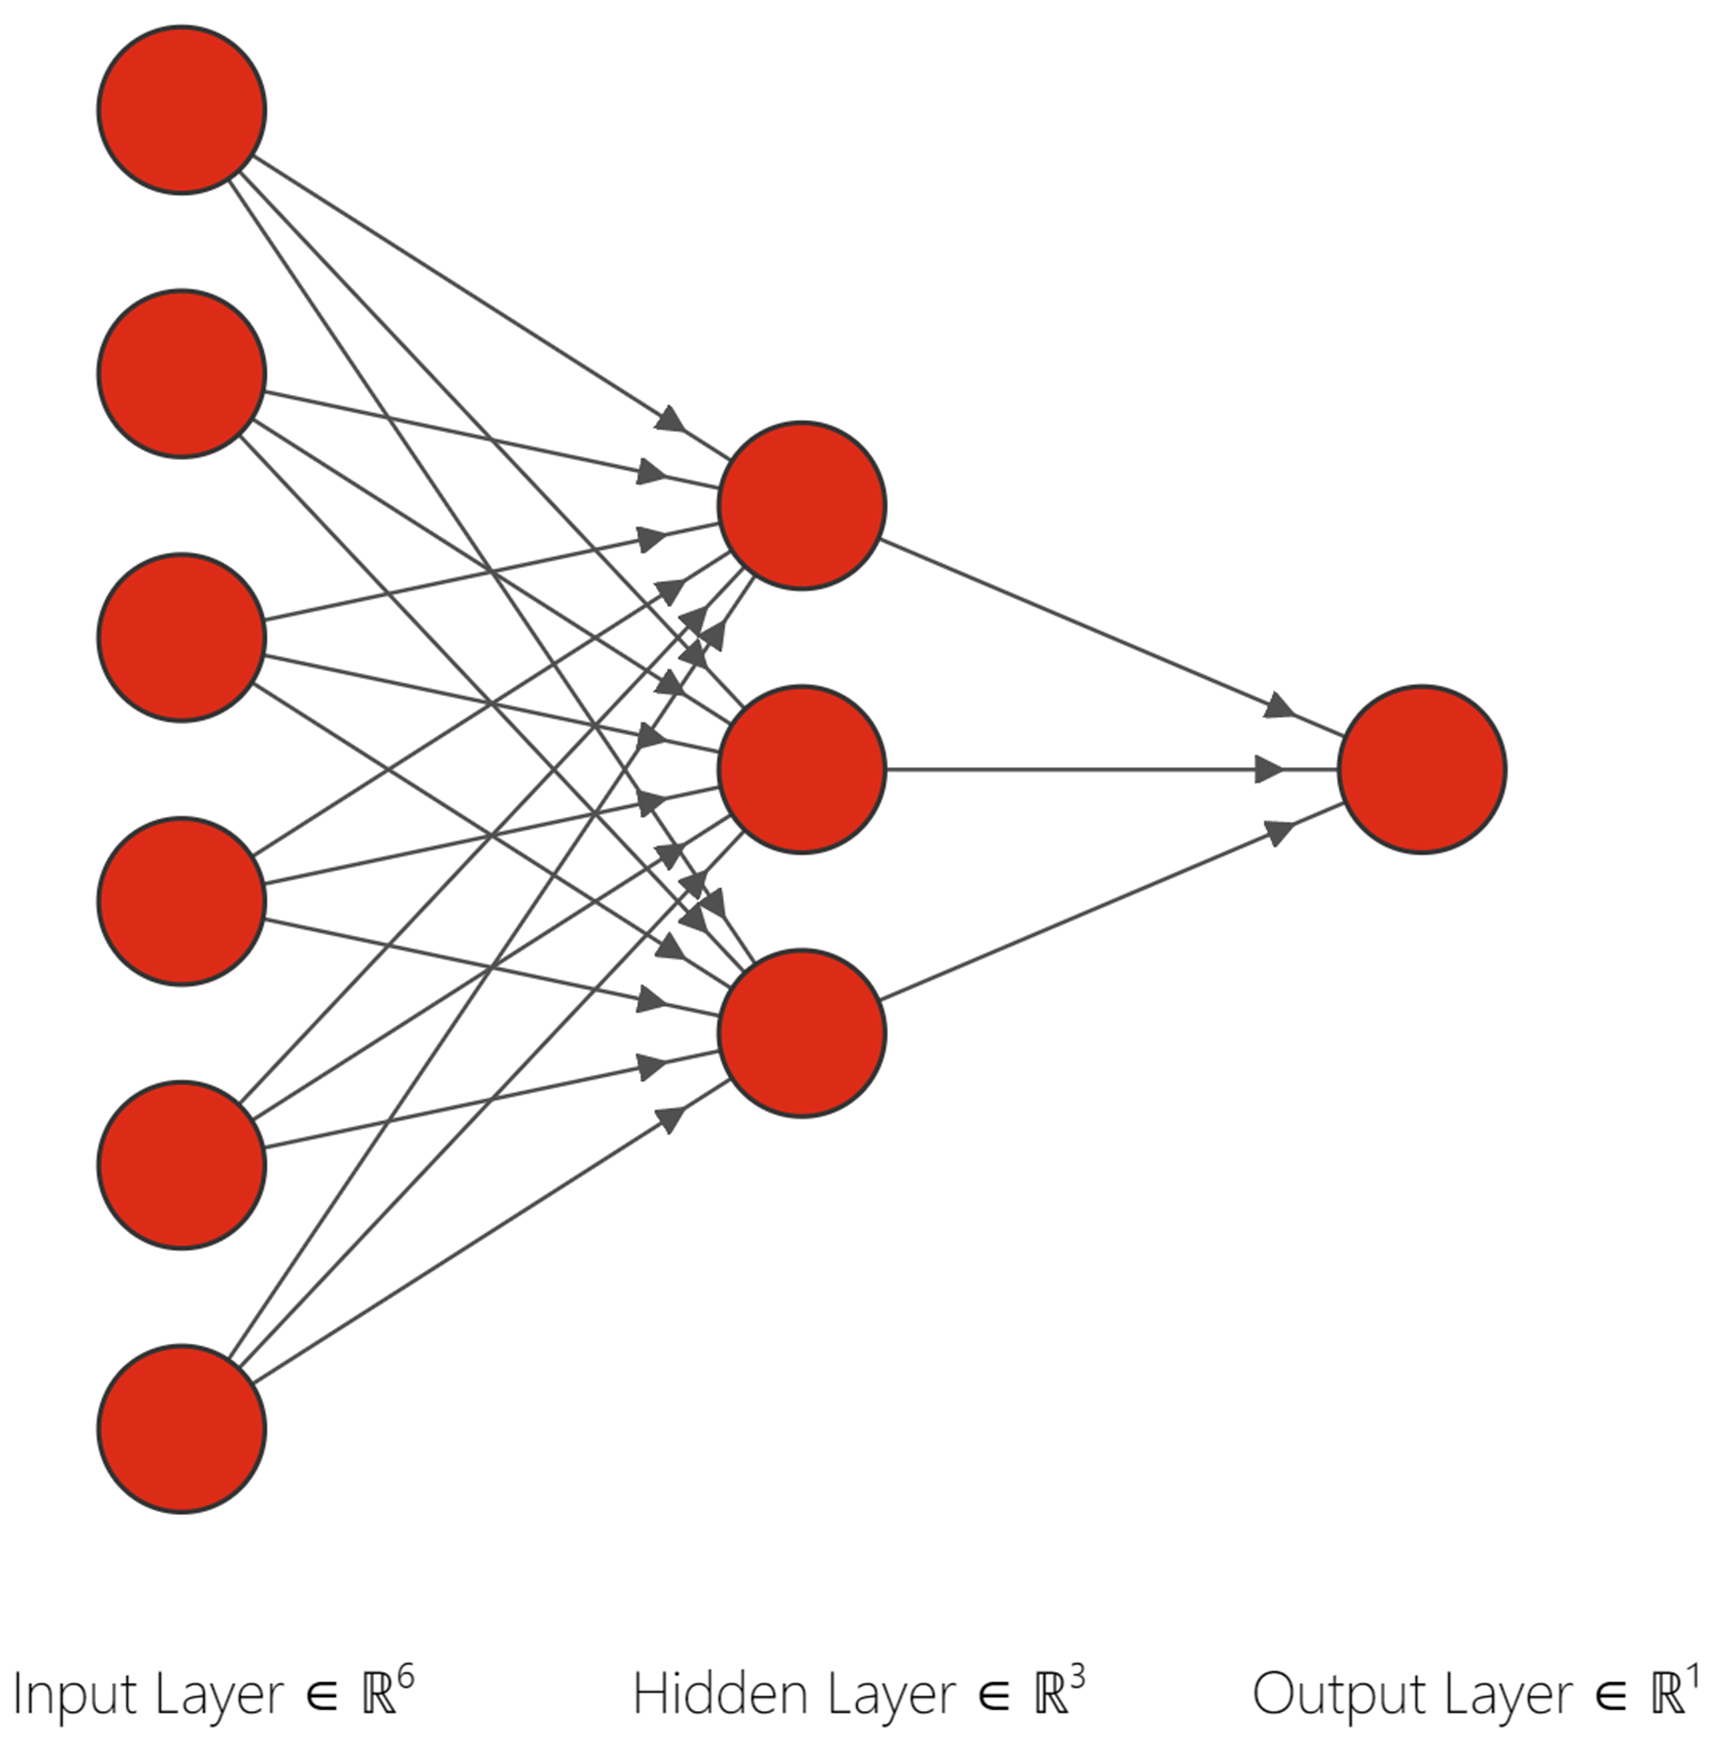
</div>

### Bias Alert: Normalization Data Snooping bias

For neural nets we almost always need to normalize (or standardize) the input data. There is room for a weak form of data snooping bias though, in historic simulations. 
We can either normlize by row (ie across a given equity's datapoints), so that each column is in proportion to the row. Or we can normlize by column. 

For equity selection applications row level normalization makes less sense, because taking PE ratio as an example, you want to compare one equity's PE ratio versus the PE ratio of all others; ie column normalize. It makes little sense to row normalize, where a equity's PE is scaled against the same equity's EBITDA/EV.  
The bias arises when we column normalize (or standardize) training data to train our model, and then pass in new data for forecasting, which may contain different min and maxes in each column. In this case all the column scalings will slightly change if the min max range changes from the training data.
In this case we can either live with the inaccuracy, or save the min-max training range and normalize the new data to the training range, capping the min/max at the training min/max, or allowing the min/max to exceed the -1/+1 range typically used for min/max scaling.


### Bias Alert: Repeated testing (multiplicity) bias

Complex machine learning approaches generally have many hyperparameters, such as neural nets, with the number of hidden nodes, the learning rate, optimizer used, activation function and so on. It is standard practices to conduct a grid search of these hyper parameters, known as hyperparameter tuning, until we find the optimum comdination. This is a problem if we are hypothesis testing the results of our model, for instance sampling the R2, and F-stat of the goodness of fit of our prediction, because the p-val is calculated to assume the probability of one test being conducted. This is known as multiplicity bias.   

Applying many tests in a single study results in an increased probability of detecting a significant finding just by chance (the problem of multiplicity). It then discusses some of the methods that have been proposed for correcting for multiplicity, including single-step procedures (e.g., Bonferroni); multistep procedures, such as those of Holm, Hochberg, and Šidák; false discovery rate control; and resampling approaches. 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3015194/

### 3b. i) Prepare data 

We still need to calculate factor loadings at the stock level as before, but we now need to pass training data to our MLP. See the X (stock level factor loadings, assumed factor returns) and y variable (future return) we will be using below

In [28]:
# Show the training data shape to traing the MLP
X_nlf_train, y_nlf_train = NonLinearFactorInvesting.nonlinfactor_er_func_prep_data(df_tb3ms=df_tb3ms,
                               df_sec_rets=df_sec_rets,
                               df_ff_factors=df_ff_factors,
                               date_end=0,
                               func_training_period = 1)

print('X consists of stock level factor loadings, and assumed futuure factor returns')
display(X_nlf_train)
print('y consists of the stock level returns we want to forecast')
display(y_nlf_train)

X consists of stock level factor loadings, and assumed futuure factor returns


,const_coef,Mkt-RF_coef,SMB_coef,HML_coef,RMW_coef,CMA_coef,Mkt-RF_ret,SMB_ret,HML_ret,RMW_ret,CMA_ret
WW-US,-0.025969,1.440355,1.853542,0.302184,0.932241,0.635143,0.094024,0.022718,0.02916,0.066762,0.064906
WABC-US,-0.009402,0.539294,-0.252693,0.195997,-0.147992,0.632558,0.094024,0.022718,0.02916,0.066762,0.064906
VVR-US,0.000141,0.578953,0.197353,0.317471,-0.289305,0.023922,0.094024,0.022718,0.02916,0.066762,0.064906
VSEC-US,0.011940,1.071620,1.591666,0.343068,1.518007,-1.765189,0.094024,0.022718,0.02916,0.066762,0.064906
VCV-US,-0.001743,0.253667,0.274933,-0.142278,0.258173,-0.360098,0.094024,0.022718,0.02916,0.066762,0.064906
...,...,...,...,...,...,...,...,...,...,...,...
ALIM-US,-0.037135,1.039423,3.323593,-0.519855,1.922321,2.919687,0.094024,0.022718,0.02916,0.066762,0.064906
ALG-US,0.004417,0.897478,0.064272,0.455259,-0.329896,-0.644611,0.094024,0.022718,0.02916,0.066762,0.064906
AGM-US,0.011637,0.558673,0.574907,0.839610,0.682009,-1.171236,0.094024,0.022718,0.02916,0.066762,0.064906
ACAD-US,0.004765,0.177528,1.306308,-0.613448,-0.428234,0.272364,0.094024,0.022718,0.02916,0.066762,0.064906


y consists of the stock level returns we want to forecast


,ALL
WW-US,-0.496498
WABC-US,0.005709
VVR-US,0.033591
VSEC-US,0.069416
VCV-US,-0.075549
...,...
ALIM-US,0.065366
ALG-US,0.123551
AGM-US,0.146499
ACAD-US,-0.280671


### 3b. ii) Forecast Equity Level Expected Returns

Now we need functions to generate factor loadings at the stock level, then to train our neural net, and to provide the final forecast of equity returns in a given time period. We will need these function to generate expected returns.

#### Example: Expected Returns at a Single Time Point 
We can test our model, training it at a specific time point to observe the residuals of our model.

p-value may not be accurate for N > 5000.


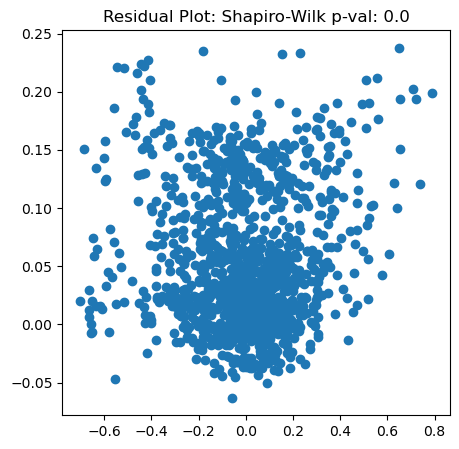

R2: 0.08; F-stat: 10.76


In [29]:
# train nn 
nn_model, X_nlf, y_train_nlf, y_hat_nlf = NonLinearFactorInvesting.nonlinfactor_train_er_func(df_tb3ms=df_tb3ms, 
                                              df_sec_rets=df_sec_rets,
                                              df_ff_factors=df_ff_factors,
                                              date_end=0,
                                              forecast_ahead=6,
                                              window_size=36,
                                              func_training_period=12,
                                              plot_residual_scatter=True)


Now we can implement a function that applies the forecasting function over the study term, ready for historic simulation testing.

In [30]:

# Run the function with our data
df_nlf_all_er, nn_mod_latest = NonLinearFactorInvesting.nonlinfactor_forecast_all_er(df_benchmark_trades=df_benchmark_trades, # which equities to include?
                                                            df_tb3ms=df_tb3ms, 
                                                            df_sec_rets=df_sec_rets,
                                                            df_ff_factors=df_ff_factors, # factor return data
                                                            window_size= 36, # period to calculate equity loadings over
                                                            func_training_period=1) # how many periods should we stack up to train the MLP

0it [00:00, ?it/s]

### Bias Alert: Complexity Bias
Using a complex model such as a neural net may be appealing but number of parameters the model needs to have trained may exceed our rule of thumb for complexity. It may in anycase, not an ideal learner to apply, if a more simple approach achieves a similar result. 


In [32]:
# count the number of parameters in the MLP
param_count = 0
for i in range(0, nn_model.coefs_.__len__()):
  param_count += nn_model.coefs_[i].shape[0]


# Sanity Check: Biases ************************
failed, _, _ = RobustInvestmentUtils.bias_complexity_check_regression(no_of_instances=36, # Try to use  36month window to train the MLP
                                    no_of_features=X_nlf.shape[1]-1, # Do not count intercept
                                    no_of_parameters=param_count) 
if failed == True:
  print("************ Complexity bias warning ***************")  
# Sanity Check: Biases ************************

************ Complexity bias warning ***************


### 3b. iii) Construct Model Portfolios,  iv) Simulate Returns

Again, based on expected returns from the model, we construct model portfolios over the study term, and then run our historic simulation. We will also chart the returns of our benchmark and other simulation returns as a comparator. 

0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

Run simulations from a common start date...


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Generate charts...


,Analytics
Total Return (TR)(annualized),0.134772
Standard deviation (SD) (annualized),0.295822
Sharpe Ratio (TR/SD),0.455584
Hit rate (monthly),0.571429


,Descriptive Stats
Mean (TR),0.014331
Median (TR),0.006426
Variance (TR),0.007293
Skewness (TR),-0.038435
Kurtosis (TR),1.011410


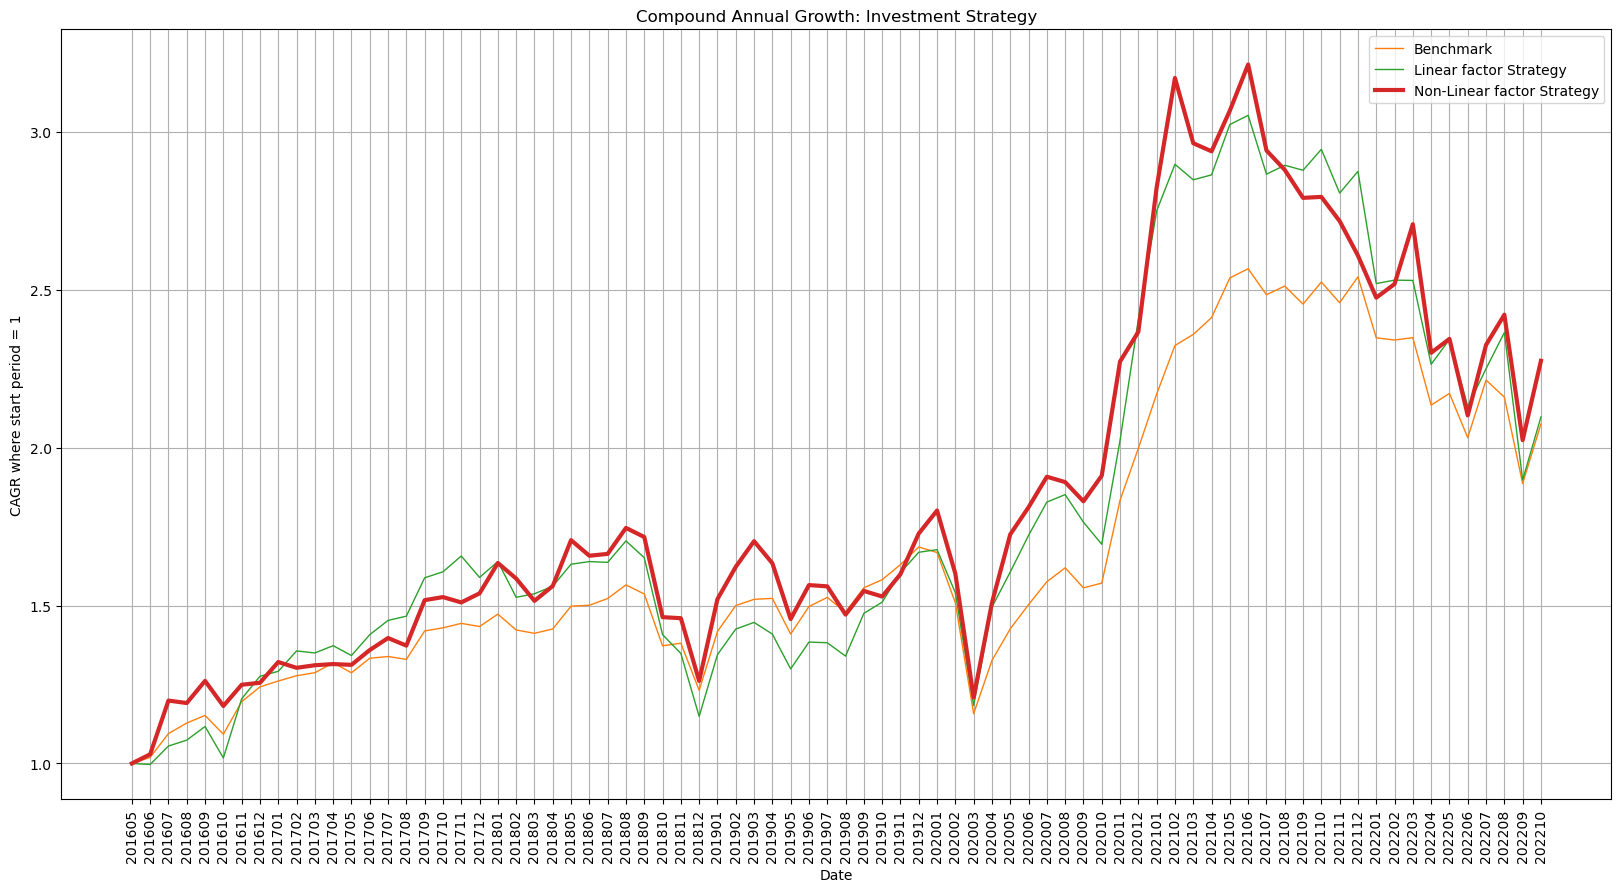

In [35]:
# Run the function to establish simple trades
df_nlf_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_nlf_all_er, rebalance_freq=6, min_quantile_to_buy=0.75)

# Get the min common start date for the simulations (given the different training data windows they might use) so as we can compare them
start_date = min(int(SimulationUtils.start_period_trades(df_trades)),
                 int(SimulationUtils.start_period_trades(df_nlf_trades)),
                 int(SimulationUtils.start_period_trades(df_benchmark_trades)))

# Plot the non-linear-factor model CAGR vs the benchmark
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, 
                         rebalance_freq=6, 
                         df_sec_rets=df_sec_rets,
                         print_chart=False)  

# Run sims from the same start date.
print('Run simulations from a common start date...')
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  

# Chart
print('Generate charts...')
p = SimulationUtils.sim_chart(df_non_lin_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_non_lin_sec_cagr.sum(axis=1, skipna=True), 'Non-Linear factor Strategy', emphasize=True)
p.legend()
p.show()

0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

Run simulations from a common start date...


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Generate charts...


,Analytics
Total Return (TR)(annualized),0.134772
Standard deviation (SD) (annualized),0.295822
Sharpe Ratio (TR/SD),0.455584
Hit rate (monthly),0.571429


,Descriptive Stats
Mean (TR),0.014331
Median (TR),0.006426
Variance (TR),0.007293
Skewness (TR),-0.038435
Kurtosis (TR),1.011410


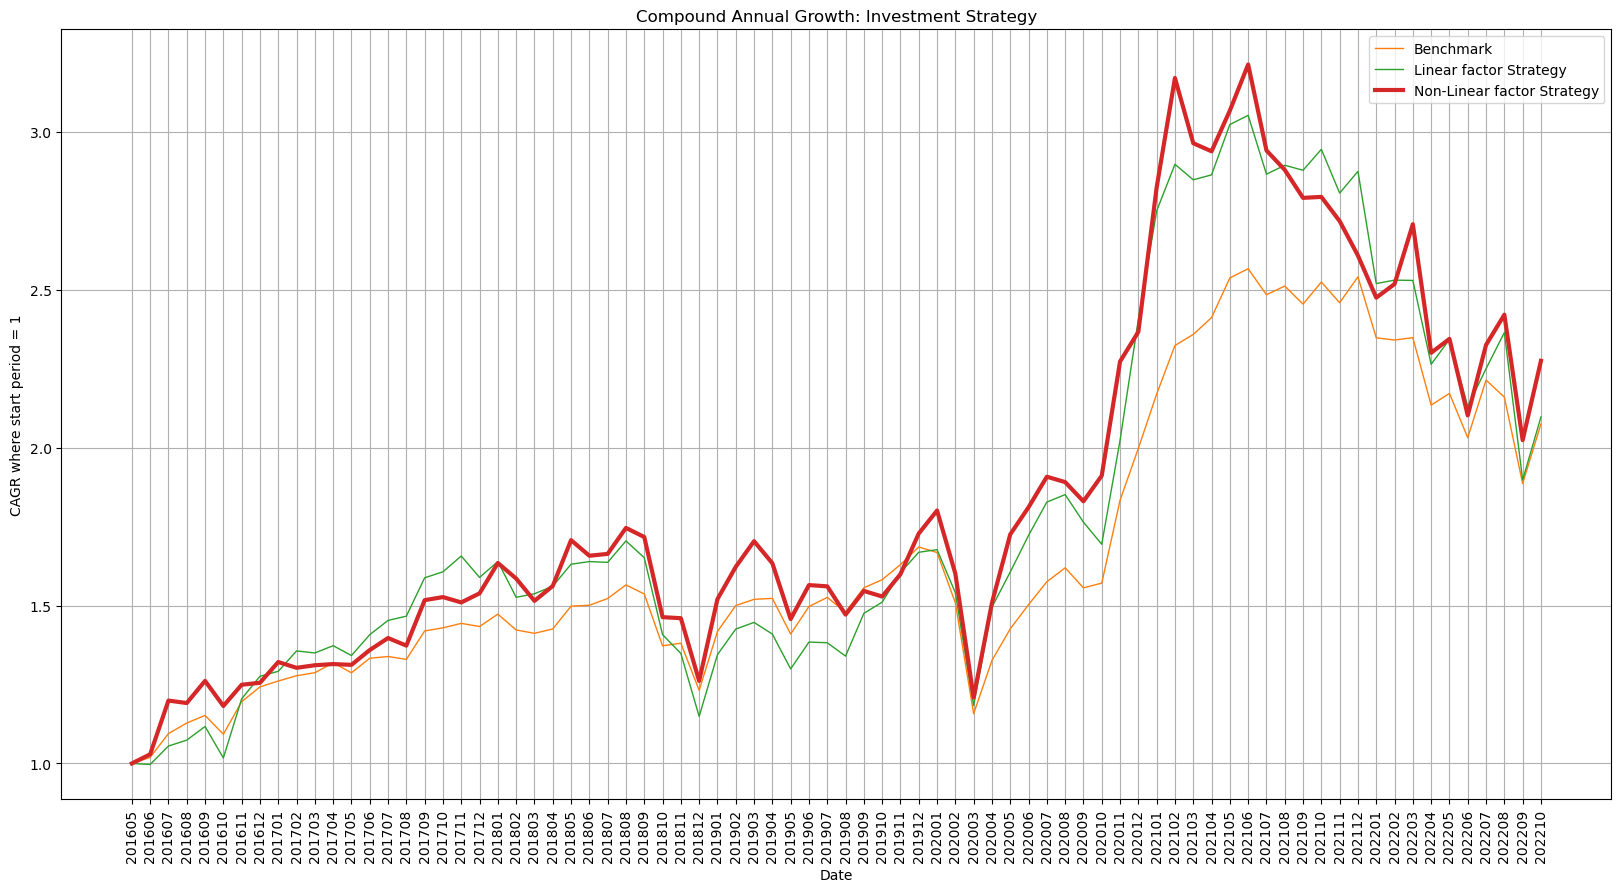

In [33]:
# Run the function to establish simple trades
df_nlf_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_nlf_all_er, rebalance_freq=6, min_quantile_to_buy=0.75)

# Get the min common start date for the simulations (given the different training data windows they might use) so as we can compare them
start_date = min(int(SimulationUtils.start_period_trades(df_trades)),
                 int(SimulationUtils.start_period_trades(df_nlf_trades)),
                 int(SimulationUtils.start_period_trades(df_benchmark_trades)))

# Plot the non-linear-factor model CAGR vs the benchmark
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, 
                         rebalance_freq=6, 
                         df_sec_rets=df_sec_rets,
                         print_chart=False)  

# Run sims from the same start date.
print('Run simulations from a common start date...')
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  

# Chart
print('Generate charts...')
p = SimulationUtils.sim_chart(df_non_lin_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_non_lin_sec_cagr.sum(axis=1, skipna=True), 'Non-Linear factor Strategy', emphasize=True)
p.legend()
p.show()

### 3b. v) Assess Returns

First we need to understand how the NonLinear Factor Model is driving its returns, but we are using a black-box model which makes this difficult. To address this we use the SHAP explainable AI (XAI) package to examine how the input data is driving outputs of the model, using parameter importance.

  0%|          | 0/25 [00:00<?, ?it/s]

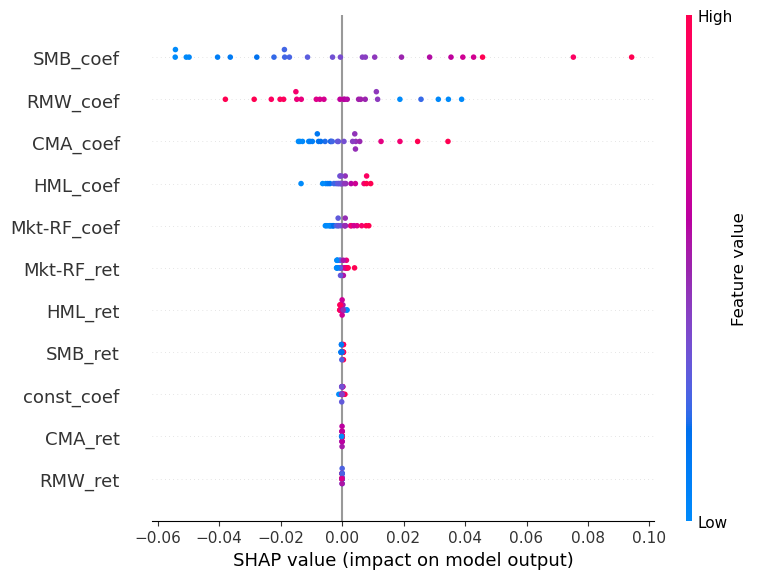

In [38]:
import shap

# This can take a while
# SHAP XAI on the training data
samples_to_use = 25
X_nlf_sample = shap.sample(X_nlf, samples_to_use)
explainer = shap.KernelExplainer(nn_model.predict, X_nlf_sample)

with warnings.catch_warnings(): # Supress warnings
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(shap.sample(X_nlf, samples_to_use))
    shap.summary_plot(shap_values, X_nlf_sample.values, feature_names=X_nlf_sample.columns)

Now we examine whether the returns are unusually good (or bad) using the target shuffling lite approach. From the chart below we can see that the model produces very average performance (vertical back line), similar to the benchmark.

Non-linear Factor Model


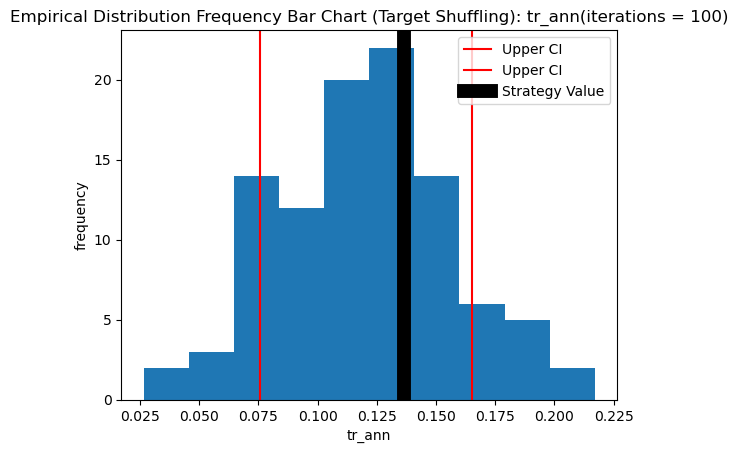

Empirical probability value of the strategy: tr_ann:0.67


In [39]:
# check the performance of the simultation using target shuffling lite, to form an empirical distributon of returns
# simulation...
print('Non-linear Factor Model')
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_non_lin_sec_cagr)

## 3c. Interpretable Machine Learning Approach


An alternative to enhancing traditional quant investing with ML is to use a purpose designed ML approach. We will use Symbolic artificial intelligence (SAI) [1], an investment rules-learning ML approach which aims to avoid many of the biases in traditional quantitative investing, and potential biases in combining traditional quantitative investing with ML.

[1] Philps, D., Tilles, D., & Law, T. (2021). Interpretable, Transparent, and Auditable Machine Learning: An Alternative to Factor Investing. The Journal of Financial Data Science, 3(4), 84-100 https://jfds.pm-research.com/content/early/2021/09/22/jfds.2021.1.077



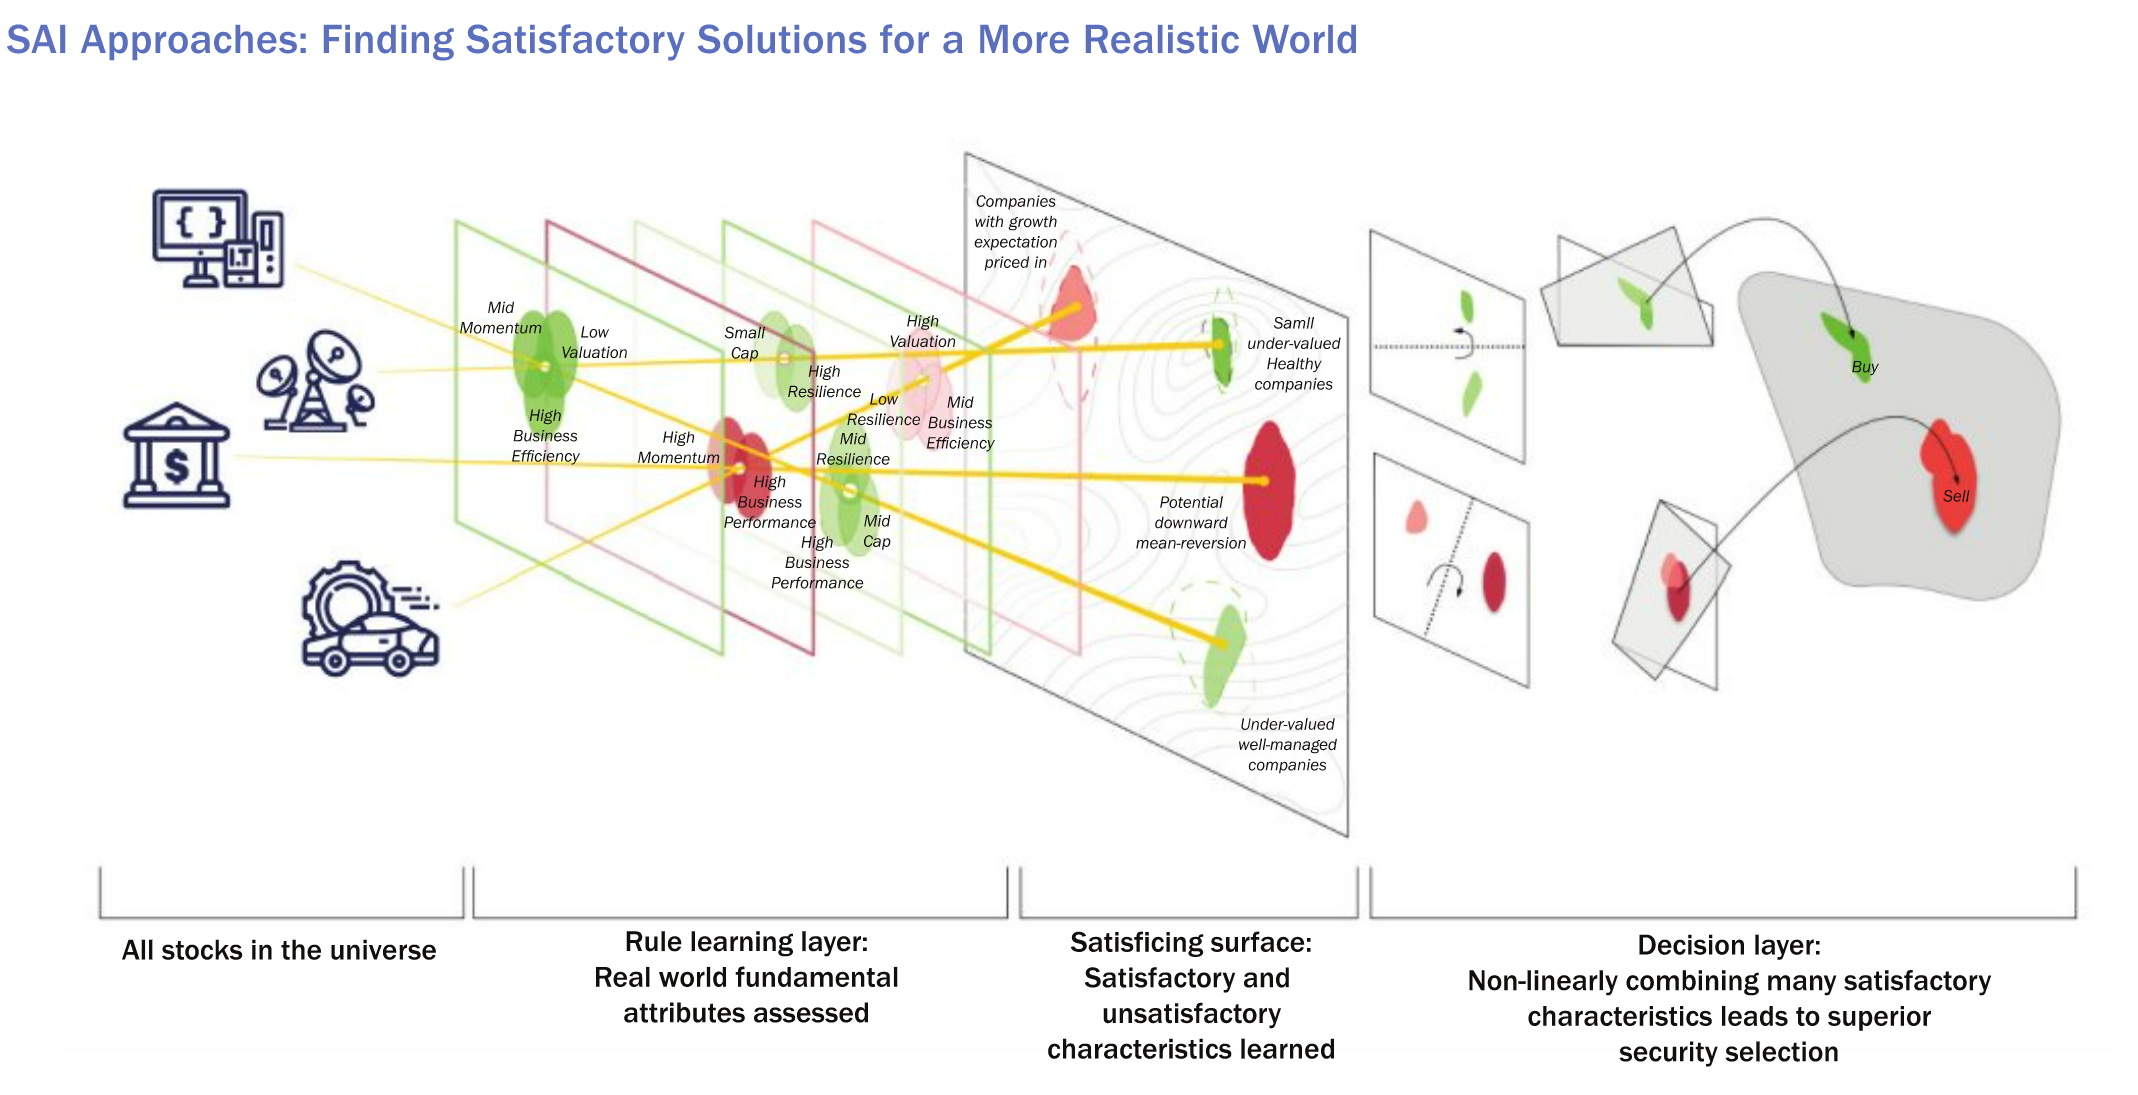

Import the SAI package...

In [40]:
from investsai.sai import SAI 

### 3c. i) Prepare Data
We will use the same factor loadings data we used previously, except SAI can be trained on factor loadings fom many time periods (we use 3 below: func_training_period=3). Our ground truth is stocks that generate a total return in the top 25% of the universe in 6months time (forecast_ahead=6).

In [41]:
# Get training and test data to pass into SAI 
sai_X, sai_y = SAIInvesting.sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                  df_sec_rets=df_sec_rets,
                                  dic_fundamentals=None, #<< Pass populated dict None,
                                  df_ff_factors=df_ff_factors,
                                  date_end=0,
                                  buysell_threshold_quantile=0.75,
                                  forecast_ahead=6, # << Forecasting 6months ahead
                                  window_size=36, # << Calculate factor loadings over this period
                                  func_training_period=3) ## << Use this many periods to train SAI
sai_X

,const,mkt-rf,smb,hml,rmw,cma
ticker,,,,,,
WW-US_6,-0.028410,1.372966,0.832483,0.826289,0.892911,2.461892
WABC-US_6,-0.003796,0.778416,-0.683279,0.467586,-0.706559,0.480911
VVR-US_6,0.000898,0.683009,0.075910,0.314441,-0.589197,-0.074256
VSEC-US_6,0.000575,0.511750,2.807850,-0.233746,2.526712,-2.104904
VCV-US_6,0.005163,0.366195,-0.221341,0.105780,-0.293277,-0.043113
...,...,...,...,...,...,...
ALIM-US_8,0.005773,1.084224,2.525580,0.621924,0.480730,2.897863
ALG-US_8,0.009061,0.674030,0.430520,0.398574,-0.081694,-0.830120
AGM-US_8,0.003667,0.382614,1.565415,0.150780,1.941787,-0.712420


Note: In the SAI training data above we have stacked factor loadings for all the equities in our universe for periods 6, 7, and 8 (note the "_6" suffix for the security tickers for data from period 6 for example). As we specified a "date_end=0", but a "forecast_ahead=6" SAI will use data from 6 periods ago to train the model with a y-variable from "date_end=0". This it to avoid data-snooping. We have 3 periods in the training data (6,7,8) owing to "func_training_period=3".

### 3c. ii) Forecast Equity Level Expected Returns


In [42]:
# Train our SAI model (factor loadings data only)
sai_mod, sai_X, sai_y, sai_y_hat = SAIInvesting.sai_train_er_func(df_tb3ms=df_tb3ms, 
                                  df_sec_rets=df_sec_rets,
                                  dic_fundamentals=None,
                                  df_ff_factors=df_ff_factors,
                                  date_end=0, #<< Training a model at the latest date
                                  buysell_threshold_quantile=0.75, #<< Predict stocks in the top 25% of return outcomes 
                                  lift_cut_off=1.25, #<< Only learn rules where the lift >125%
                                  forecast_ahead=6, #<< predict stocks returns in 6monmths time.
                                  window_size=36, #<< Factor loadings calculated over 36months
                                  func_training_period=12, #<< SAI training data will use 12x months of stacked loadings for the equity universe
                                  show_analytics=True)



...................................
   training Invest-SAI algorithm   
...................................


....................................
            predicting             
...................................



We can review the investment rules SAI has learned, where the first rule (smb_3, rmw_3) indicate equities need to satisfy "smb_3" and "rmw_3": where "smb_3" indicates a SMB loading in the top third (tercile) of the equity universe, "rmw_3" is a robustness loading in the top third of the universe. We can review the conditional success probability (cond_success_prob), odds ratio (odd_ratio) and lift (causal_lift) of each of our rules to understand how powerful each of them is.

Note that this outcome is different from factor based investing which would typically allow a high loading in another beneficial factor to overcome weaknesses in SMB and RMW. SAI is telling us that a higher SMB and RMW are non-negotiable in this rule-set.

In [43]:
# Rules our model will be using, needing to show a reasonable "lift"
sai_mod.rules[(sai_mod.rules['causal_lift']>1.25)].reset_index(drop=True)

,rules,cond_success_prob,odd_ratio,causal_lift
0,"(mkt-rf_2, hml_3)",0.450617,2.848417,1.802469
1,"(smb_3, cma_1)",0.380711,2.076202,1.522843
2,(smb_3),0.372845,2.558056,1.491379
3,"(rmw_3, smb_3)",0.357357,2.015467,1.429429
4,"(rmw_3, cma_1)",0.347032,1.760490,1.388128
5,"(cma_1, hml_3)",0.319392,1.537583,1.277567
6,(mkt-rf_2),0.316810,1.677245,1.267241
7,(hml_3),0.312500,1.623377,1.250000


We can now apply this same process across the full study term, generating rules in each period to drive expected return forecasts in each.

In [44]:
# Run the function with our factor loadings data
df_sai_all_er, sai_mod_latest = SAIInvesting.sai_forecast_all_er(df_benchmark_trades=df_benchmark_trades,
                                                    df_tb3ms=df_tb3ms, 
                                                    df_sec_rets=df_sec_rets,
                                                    dic_fundamentals=None,
                                                    df_ff_factors=df_ff_factors,
                                                    date_end=0,
                                                    buysell_threshold_quantile=0.75,
                                                    lift_cut_off=1.25, #<< Only learn rules where the lift >125%
                                                    forecast_ahead=6,
                                                    window_size=36,
                                                    func_training_period=1)



0it [00:00, ?it/s]

### 3c. iii) Construct Model Portfolios, iv) Simulate Returns



In [ ]:
# Run the function to establish simple trades
df_sai_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_sai_all_er, rebalance_freq=6, min_quantile_to_buy=0.8)

# Get the min common start date for the simulations (given the different training data windows they might use) so as we can compare them
start_date = min(int(SimulationUtils.start_period_trades(df_sai_trades)),
                 int(SimulationUtils.start_period_trades(df_trades)),
                 int(SimulationUtils.start_period_trades(df_nlf_trades)),
                 int(SimulationUtils.start_period_trades(df_benchmark_trades)))

# Plot the non-linear-factor model CAGR vs the benchmark
df_sai_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_sai_trades, 
                         rebalance_freq=6, 
                         df_sec_rets=df_sec_rets,
                         print_chart=False,
                         date_start_of_sim=start_date)  

# Run sims from the same start date.
print('Run simulations from a common start date...')
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  

# Chart
print('Generate charts...')
p = SimulationUtils.sim_chart(df_non_lin_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_non_lin_sec_cagr.sum(axis=1, skipna=True), 'Non-Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_sec_cagr.sum(axis=1, skipna=True), 'SAI Strategy', emphasize=True)
p.legend()
p.show()

### 3c. iv) SAI Model: Judging model performance

We now compare our model performance vs the empirical distribution generated by the target shuffling lite approach.

In [36]:
# check the performance of the SAI simultation using target shuffling lite, to form an empirical distributon of returns
# Simulation
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_sai_sec_cagr)

NameError: name 'df_sai_sec_cagr' is not defined

## Bias Alert: End point bias

End point bias refers to the biased selection of a given time period and end date we might use to assess a model's performance. It is notable that each approach we have tested has certain periods where it appears to be the "best", and assessing performance to the last elapsed period is to some extent aritrary. We can deal with this to some extent by using different sub-time periods to assess model performance over, perhaps coinciding with different market conditions (analytics such as hit rate can also allow us to assess consistency of return delivery). We can also test our model out-of-sample, and in subsamples, such as in different countries and sectors to assess generalization.

## 3d. SAI Using Fundamental Data

Having compared the SAI output to linear and non linear factor models, we can now train the SAI model on more than just the factor loadings, adding our unaltered fundamental data to the training also. With fundamental inputs rather than factors, we can also increase the lift our rules need to achieve to be used.

In [ ]:
# Get training and test data to pass into SAI 
sai_X, sai_y = SAIInvesting.sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                  df_sec_rets=df_sec_rets,
                                  dic_fundamentals=dict_sec_ff, #<< Pass populated dict
                                  df_ff_factors=df_ff_factors,
                                  date_end=0,
                                  buysell_threshold_quantile=0.75,
                                  forecast_ahead=12,
                                  window_size=36,
                                  func_training_period=1)
display(sai_X)

In [ ]:
# Run the function with ALL our data
# We now add our fundamental data dict to the training process, and extend the forecast term to 12m (as we are using annual accounts)
df_sai_all_features_all_er, sai_all_features_mod_latest = SAIInvesting.sai_forecast_all_er(df_benchmark_trades=df_benchmark_trades,
                                                    df_tb3ms=df_tb3ms, 
                                                    df_sec_rets=df_sec_rets,
                                                    dic_fundamentals=dict_sec_ff, #<< Pass populated dict
                                                    df_ff_factors=df_ff_factors,
                                                    date_end=0,
                                                    buysell_threshold_quantile=0.75,
                                                    lift_cut_off=1.5,
                                                    forecast_ahead=6,
                                                    window_size=36,
                                                    func_training_period=1)


In [ ]:
# Run the function to establish simple trades
df_sai_all_features_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_sai_all_features_all_er, rebalance_freq=6, min_quantile_to_buy=0.75)

# Get the min common start date for the simulations (given the different training data windows they might use) so as we can compare them
start_date = min(int(SimulationUtils.start_period_trades(df_sai_all_features_trades)), 
                 int(SimulationUtils.start_period_trades(df_sai_trades)),
                 int(SimulationUtils.start_period_trades(df_trades)),#
                 int(SimulationUtils.start_period_trades(df_nlf_trades)),
                 int(SimulationUtils.start_period_trades(df_benchmark_trades)))

# Plot the non-linear-factor model CAGR vs the benchmark
df_sai_all_features_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_sai_all_features_trades, 
                                        rebalance_freq=6, 
                                        df_sec_rets=df_sec_rets,
                                        print_chart=False,
                                        date_start_of_sim=start_date)  

# Run sims from the same start date.
print('Run simulations from a common start date...')
df_sai_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_sai_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  

# Chart
print('Generate charts...')
p = SimulationUtils.sim_chart(df_non_lin_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_non_lin_sec_cagr.sum(axis=1, skipna=True), 'Non-Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_sec_cagr.sum(axis=1, skipna=True), 'SAI Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_all_features_sec_cagr.sum(axis=1, skipna=True), 'SAI EXTENDED FEATURES lift=1.2 Strategy', emphasize=True)
p.legend()
p.show()

We can directly examine the rules driving the latest SAI model 

In [ ]:
# Rules our model will be using, needing to show a reasonable "lift"
sai_all_features_mod_latest.rules[(sai_all_features_mod_latest.rules['causal_lift']>1.5)].reset_index(drop=True)

## 3e. More Lift?

Now ask that the rules SAI learns exhibit greater lift... We crank up the lift requirement 


In [ ]:
# Run the function with ALL our data
# We now add our fundamental data dict to the training process, and extend the forecast term to 12m (as we are using annual accounts)
df_sai_all_lift2_features_all_er, sai_all_lift2_features_mod_latest = SAIInvesting.sai_forecast_all_er(df_benchmark_trades=df_benchmark_trades,
                                                    df_tb3ms=df_tb3ms, 
                                                    df_sec_rets=df_sec_rets,
                                                    dic_fundamentals=dict_sec_ff, #<< Pass populated dict
                                                    df_ff_factors=df_ff_factors,
                                                    date_end=0,
                                                    buysell_threshold_quantile=0.75,
                                                    lift_cut_off=3.0, # << Increase the lift for the rules
                                                    forecast_ahead=6,
                                                    window_size=36,
                                                    func_training_period=1)

In [ ]:
# Run the function to establish simple trades
df_sai_all_lift2_features_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_sai_all_features_all_er, rebalance_freq=6, min_quantile_to_buy=0.75)

# Get the min common start date for the simulations (given the different training data windows they might use) so as we can compare them
start_date = min(int(SimulationUtils.start_period_trades(df_sai_all_lift2_features_trades)), 
                 int(SimulationUtils.start_period_trades(df_sai_all_features_trades)), 
                 int(SimulationUtils.start_period_trades(df_sai_trades)),
                 int(SimulationUtils.start_period_trades(df_trades)),
                 int(SimulationUtils.start_period_trades(df_nlf_trades)),
                 int(SimulationUtils.start_period_trades(df_benchmark_trades)))

# Plot the non-linear-factor model CAGR vs the benchmark
df_sai_all_lift2_features_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_sai_all_lift2_features_trades, 
                                        rebalance_freq=6, 
                                        df_sec_rets=df_sec_rets,
                                        print_chart=False,
                                        date_start_of_sim=start_date)  

# Run sims from the same start date.
print('Run simulations from a common start date...')
df_sai_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_sai_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  

# Chart
print('Generate charts...')
p = SimulationUtils.sim_chart(df_non_lin_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_non_lin_sec_cagr.sum(axis=1, skipna=True), 'Non-Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_sec_cagr.sum(axis=1, skipna=True), 'SAI Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_all_features_sec_cagr.sum(axis=1, skipna=True), 'SAI EXTENDED FEATURES lift=1.2 Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_all_lift2_features_sec_cagr.sum(axis=1, skipna=True), 'SAI EXTENDED FEATURES lift=2 Strategy', emphasize=True)
p.legend()
p.show()

In [ ]:
# Rules our model will be using, needing to show a reasonable "lift"
sai_all_lift2_features_mod_latest.rules[(sai_all_lift2_features_mod_latest.rules['causal_lift']>3.00)].reset_index(drop=True)

## 3f. Superior Ground Truthing using SAI

A further feature of the SAI approach is to target multiple outcomes, also know as multi-task learning, where we can set the **ground truth** of our problem to multiple objectives and not just identifying superior returns as traditional quantitative models do. With multitask learning we can train an SAI model that aims to identify equities that may generate superior returns **AND** superior US$ earnings, **AND** good down-side capture, and so on. As a result SAI can target more complex ground truths, to increase the chance equities selected are "right for the right reasons". This is also likely to result in a more robust modelling outcome, owing to one set of model parameters needing to achieve multiple, hopefully compatible, and intuitively causal objectives.
This can be achieved by simply specifying SAI's y-variable with the multiple conditions required to support the ground truth. 


# Stage4: Model Deployment

As we have alrteady seen with the Credit Use Case, model deployment requires 

Investment model deployment requires a rigorous change process, several levels of testing and sign off, asignment of responsibilities for the live operation of the process, models and data before deployiong the code to the cloud (or on native hardware). 
A key part of this stage is monitoring of data drift, and the monitoring of stakeholder KPIs which are principally for investors, and compliance needs.
For investors, the characteristics of the strategy that were marketed and agreed with the investor, should be monitored and reported regularly with sufficient executive oversight and repotring to support it.
For Compliance, regular checking that the investment elements of the strategy are fully compliant with the investment management agreement (IMA), which organisations will tend to have in place as a separate system in any case. 


# Stage 5: Model Monitoring and Reporting

##Stage5a: Data Drift

Our model is now in production and being used in practice. We need to monitor its stability. One approach is to monitor the distribution of the input data versus the data the model was trained with . If the distributions have shifted the model outcomes could be invalidated. Here we use our function data_drift_psi to monitor data drift.

Is it time for us to retrain our model?

In [ ]:
# Get Data
#================================  
sai_train_X, sai_train_y = SAIInvesting.sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                df_sec_rets=df_sec_rets,
                                dic_fundamentals=dict_sec_ff,
                                df_ff_factors=df_ff_factors,
                                date_end=0,  #<< Latest period
                                func_training_period=6,
                                buysell_threshold_quantile=0.75,
                                forecast_ahead=6, #<< Latest period
                                window_size=36) #<< Latest period

sai_test_X, sai_test_y = SAIInvesting.sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                df_sec_rets=df_sec_rets,
                                dic_fundamentals=dict_sec_ff,
                                df_ff_factors=df_ff_factors,
                                date_end=1,  #<< Latest period
                                func_training_period=1,
                                buysell_threshold_quantile=0.75,
                                forecast_ahead=0, #<< Latest period
                                window_size=36) #<< Latest period


# The test data may not contain all the columns in the train data. 
# we can add nan columns for the missing columns....
# Add blank column if a column exists in the training data and NOT in the test
missing_cols_to_add = [col for col in sai_test_X.columns if col not in sai_train_X.columns]
sai_train_X[[missing_cols_to_add]] = np.nan
missing_cols_to_add = [col for col in sai_train_X.columns if col not in sai_test_X.columns]
sai_test_X[[missing_cols_to_add]] = np.nan

# Prepare train and test data for data drift check
train_datadrift = sai_train_X # pd.concat([sai_train_X, sai_train_y], axis=1)
test_datadrift = sai_test_X # pd.concat([sai_test_X, sai_test_y], axis=1)

# Data drift check...
data_drift_features = GovernanceUtils.data_drift_psi(train_datadrift, test_datadrift, buckettype='bins',buckets=10,axis=1,single_variable=False)
data_drift_target = data_drift_features[-1]

# Print out the target PSI value:
print("Target PSI value is ",data_drift_target, "\n" )


## Stage5b: Challenger Models

We have tested three types of equity selecion model in this notebook. We have selected the SAI approach, but we could still use the other models to provide another check on our live model, ie a **challenger model**.


# Afterword

We have done our best to include the key themes of what we think are the critical stages of model development in this notebook, but clearly in practice many more checks and details would be added to each of the 5 model development stages to best ensure stakeholder's KPIs are met, and Governance standards would be as high as possible. Hopefully our example and key themes will provide insight to avoid many of the classic biases in model development.